# LCPA 23-24 - "Hierarchical mergers of binary black holes"


<center><h1>Group 07</h1></center>


<center><style>
table {
    font-size: 24px;
}
</style></center>

| Last Name          | First Name            |Student Number|
|--------------------|-----------------------|----------------|
| Bertinelli         | Gabriele              |2103359         |
| Boccanera          | Eugenia               |                |
| Cacciola           | Martina               |2097476         |
| Lovato             | Matteo                |                |           


# **<span style="color:red"> TO-DO: </span>**

- **Plots**:
  - Mass distribution hist -> maybe select 3 met. Same met diff hosting body. Show median
  - N° of generation per hosting body
  - BH_mass vs escape vel 
  - Mass vs met
  - Other distribution plot: mass vs mass and others

- **Data**:
  - Filter data for time_merge $\leq$ t_H $ \sim 13.6\, Gyr$

- **Visualization**:
  - Do some PCA(?) -> maybe time consuming and useless

- **Models**:
  - Implement functions for simple XGBoost, and GridSearch XGBoost
  - Compare results between RF and XGB
  - Function for SHAP values: violin and bar plot 

- **Analysis**:
  - The idea is to split the analysis in 2 parts:
    - Based on the features of the BHs generations, understand to which host body belongs the binary system: as label used `label` -> so we are classifying the system with labels the host body (0 -> GC, 1 -> nSC, 2 -> ySC). The features importance will tell us which features are the most important in understand where a system belongs.
    - Analyze each host body independently. To each system a new label `label_ngen` is given. 0 if a binary systems do not evolve and remain in the 2nd generation; 1 if the system evolves further from the 2nd gen.  
    Analyzing the features importance of this classification problem will tell us which are the most important features that make a binary BH system evolve further from the 2nd gen. To understand in great detail this, we'll use the SHAP values (below there's a in-depth discusssion) 
  

### SHAP Values

[SHAP](https://shap.readthedocs.io/en/latest/) (SHapley Additive exPlanations) values are a method used to explain the predictions of machine learning models. They were introduced by [Lundberg and Lee](https://papers.nips.cc/paper_files/paper/2017/file/8a20a8621978632d76c43dfd28b67767-Paper.pdf) in 2017 and are based on cooperative game theory.

SHAP values provide a way to allocate the contribution of each feature in a prediction model to the final prediction. They aim to quantify the impact of each feature on the prediction outcome by considering all possible combinations of features and calculating the contribution of each feature in each combination.

The core idea behind SHAP values is the concept of [Shapley values](https://en.wikipedia.org/wiki/Shapley_value), which is a method for fairly distributing the payout of a cooperative game among the players based on their individual contributions. In the context of machine learning models, the features are treated as players, and the prediction outcome is the payout.

To calculate SHAP values, a baseline reference is established, which serves as a starting point for the feature contributions. Then, different combinations of features are created, and for each combination, the model predictions are observed. The contribution of each feature is determined by comparing the predictions with and without the feature included.

SHAP values provide several advantages in interpreting machine learning models. They offer a unified framework for feature importance measurement that is both consistent and locally accurate. They also satisfy desirable properties such as consistency, meaning that if a feature is removed or added, the SHAP values change accordingly. Furthermore, SHAP values can be used to explain individual predictions as well as provide an overview of feature importance across the entire dataset.

In our study, we employed three types of visualizations to gain insights into the importance of each feature*.

Summary plot (bar type) for global inspection
This kind of plot examine the mean absolute SHAP value for each feature across all of the data. This quantifies, on average, the magnitude of each feature's contribution towards the predicted label. If a feature has a high mean SHAP value, it suggests that it generally has a strong influence on the predictions. Conversely, a low mean SHAP value indicates that the feature has less impact on the model's predictions. Mean absolute SHAP values are essentially a drop-in replacement for more traditional feature importance measures but have two key advantages:

Mean absolute SHAP values are more theoretically rigorous, and relate to which features impact predictions most. Conventional feature importances are measured in more abstract and algorithm-specific ways, and are determined by how much each feature improves the model's predictive performance.
Mean absolute SHAP values have intuitive units, like the target variable. Feature importances are often expressed in counterintuitive units based on complex concepts such as tree algorithm node impurities.
The features are presented in descending order of importance, with the most significant feature listed at the top and the less significant features listed towards the bottom.

Summary plot (bar type) for labels inspection
We created separate plots for each label to gain a more accurate understanding of the feature importance. By examining the importance of features for each label individually, we obtained specific insights into their contributions to the prediction accuracy for each class.

Summary plot (violin type) for each label (evolution channel)
This is the most useful type of plot for our study. A SHAP violin plot provides a visual representation of the distribution of SHAP values for different features in the model. It helps in understanding the impact of each feature on the model's predictions.

Vertical Axis: The vertical axis represents the features in the model. The features are presented in descending order of importance.

Horizontal Axis: The horizontal axis represents the range of SHAP values. It spans from negative to positive values, indicating the direction and magnitude of the feature's influence on the predictions.

Violin Shape: Each violin-shaped distribution represents the density of the SHAP values for a specific feature. The width of the violin at a given point represents the density or frequency of SHAP values at that point.

A wider section of the violin indicates a higher density of SHAP values, indicating a stronger influence of the feature on the predictions.
A narrower section of the violin indicates a lower density of SHAP values, suggesting a weaker influence.
Original value: Color shows whether that variable is high (in red) or low (in blue) for that observation.

The SHAP violin plot allows you to compare the distributions of SHAP values across different features. It helps identify features that have consistent and impactful contributions (wider violins with higher densities) and those that have less influence (narrower violins with lower densities).

The plot can also reveal features with bimodal or asymmetric distributions, indicating the presence of different subgroups or distinct patterns in the data that affect the predictions differently.

* ref1: https://www.aidancooper.co.uk/a-non-technical-guide-to-interpreting-shap-analyses/
* ref2: https://medium.com/dataman-in-ai/explain-your-model-with-the-shap-values-bc36aac4de3d

## Import modules

In [3]:
import numpy as np
import pandas as pd
import polars as pl 

import matplotlib.pyplot as plt
import hvplot
import seaborn as sns

import numpy.typing as npt
from typing import Optional, Tuple, Callable, Union, List

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

## Dataset creation

In [4]:
def create_dataset(path: str, folders: List[str], mets: List[str], cols: List[str]) -> pl.DataFrame:

    """
    Function that takes in input a list of folders and a list of metallicities.
    It returns a polars lazy DataFrame with all the data from the folders and metallicities.

    :params path: path to the data parent folder (remember to add the final '/')
    :params folders: list of selected folders
    :params mets: list of selected metallicities
    :params cols: list of selected columns original names
    :return: a `polars` DataFrame with all the data from the folders and metallicities
    """

    name = 'nth_generation.txt'

    col_name = ['c' + str(i) for i in range(28)]

    for i in range(len(folders)):
        for j in range(len(mets)):

            
            file_q = pl.scan_csv(path + folders[i] + '/Dyn/' + 
                                mets[j] + '/' + name, 
                                separator = ' ', has_header=True,
                                new_columns = col_name).select(cols) # select bold columns -> most important for this analysis
            
            
            met = pl.Series([float(mets[j]) for k in range(file_q.collect().height)]) # add metallicity column

            # univocal ID given by the original ID . metallicity folder . hosting obj folder
            new_id = pl.Series(file_q.select(pl.col('c0')).cast(pl.String).collect() + '.' + str(j) + '.' + str(i))#.cast(pl.Float64)

            # hosting object label set: 0 -> GC, 1 -> nSC, 2 -> ySC
            label = pl.Series([i for _ in range(file_q.collect().height)])

            file_q = file_q.with_columns(label.alias('label'), met.alias('met'), new_id.alias('c0')) 

            if i == 0 and j==0:
                df = file_q.collect()
                
            else:
                
                df = df.vstack(file_q.collect())

    return df


def rename_columns(df: pl.DataFrame, new_cols: List[str]) -> pl.DataFrame:
    """
    Function that takes in input a DataFrame and a list of new column names (apart from the last two columns).
    It returns a DataFrame with renamed columns.

    :params df: input `polars` or `pandas` DataFrame 
    :params new_cols: list of new column names
    :return: a `polars` or `pandas` DataFrame with renamed columns
    """
    old_cols = df.columns

    rename_dict = {old_cols[i]: new_cols[i] for i in range(len(old_cols)-2)}
    df = df.rename(rename_dict)

    return df


def get_label_ngen(df: pl.DataFrame) -> pl.DataFrame:

    """
    Function that takes in input a DataFrame and returns a new column with the label for the nth generation.
     - 0 if the ID is unique, meaning that the binary systems did not evolve further (from the 2nd generation); 
     - 1 if the ID is not unique, meaning that the binary systems evolved further (from the 2nd generation).

    :param df: DataFrame
    :return: DataFrame
    """
    id_counts = df.group_by('ID').agg(pl.count('ID').alias('count'))

    # Join the count information back to the original DataFrame
    df = df.join(id_counts, on='ID', how='left')

    # Add the new column based on your condition
    df = df.with_columns(
        pl.when(df['count'] > 1)
        .then(1)
        .otherwise(0)
        .alias('label_ngen')
    )

    # Drop the temporary count column if needed
    df = df.drop('count')

    return df

In [6]:
path='./data/'

folder = ['GC_chi01_output_noclusterevolv', 'NSC_chi01_output_noclusterevolv',
               'YSC_chi01_output_noclusterevolv']
    
metallicity = ['0.0002', '0.002', '0.02', '0.0004', '0.004', '0.006', '0.0008',
                   '0.008', '0.0012', '0.012', '0.0016', '0.016']

cols = ['c0', 'c1', 'c2', 'c3', 'c4', 'c7', 'c8', 'c9', 'c13', 'c15', 'c16', 'c17', 'c25', 'c27'] # select bold columns -> most important for this analysis

new_cols = ['ID', 'bh_mass1', 'bh_mass2', 'spin1', 'spin2', 'semimajor', 'i_ecc', 'time_dyn', 'time_merge', 
'remnant_mass', 'remnant_spin', 'escape_vel', 'cluster_mass', 'n_gen']

In [7]:
df = create_dataset(path, folder, metallicity, cols)

df = rename_columns(df, new_cols)

df = get_label_ngen(df)

In [6]:
df.head()

shape: (5, 17)
┌─────────┬───────────┬───────────┬──────────┬───┬───────┬───────┬────────┬────────────┐
│ ID      ┆ bh_mass1  ┆ bh_mass2  ┆ spin1    ┆ … ┆ n_gen ┆ label ┆ met    ┆ label_ngen │
│ ---     ┆ ---       ┆ ---       ┆ ---      ┆   ┆ ---   ┆ ---   ┆ ---    ┆ ---        │
│ str     ┆ f64       ┆ f64       ┆ f64      ┆   ┆ i64   ┆ i64   ┆ f64    ┆ i32        │
╞═════════╪═══════════╪═══════════╪══════════╪═══╪═══════╪═══════╪════════╪════════════╡
│ 2.0.0   ┆ 28.497396 ┆ 23.848129 ┆ 0.734705 ┆ … ┆ 2     ┆ 0     ┆ 0.0002 ┆ 0          │
│ 18.0.0  ┆ 38.172095 ┆ 29.913274 ┆ 0.753993 ┆ … ┆ 2     ┆ 0     ┆ 0.0002 ┆ 0          │
│ 34.0.0  ┆ 60.53033  ┆ 53.519905 ┆ 0.720625 ┆ … ┆ 2     ┆ 0     ┆ 0.0002 ┆ 0          │
│ 38.0.0  ┆ 14.480868 ┆ 13.043004 ┆ 0.725751 ┆ … ┆ 2     ┆ 0     ┆ 0.0002 ┆ 0          │
│ 103.0.0 ┆ 19.224383 ┆ 15.611048 ┆ 0.742771 ┆ … ┆ 2     ┆ 0     ┆ 0.0002 ┆ 0          │
└─────────┴───────────┴───────────┴──────────┴───┴───────┴───────┴────────┴────────────┘

### Data prep

In [8]:
def data_preprocessing(df: pl.DataFrame, n_sample: int, label: str, test_size: float, random_state: int=42) -> Tuple[pd.DataFrame, pd.DataFrame, npt.NDArray, npt.NDArray, npt.NDArray, npt.NDArray]:
    
    """
    Function that takes in input a `polars` DataFrame and returns the preprocessed data for the ML model.

    :params df: input `polars` DataFrame, that will be converted into a `pandas` DataFrame
    :params n_samples: number of samples to select
    :params label: label column name
    :params random_state: random state for reproducibility
    :params test_size: test size for the train/test split
    :return: a tuple with the preprocessed data: X, y, X_train, y_train, X_test, y_test
    
    """

    df =  df.to_pandas()

    if len(df[label].unique()) == 2:

        label_counts = df[label].value_counts()
    
        # Separate majority and minority classes
        df_majority = df[df[label]==label_counts.idxmax()]
        df_minority = df[df[label]==label_counts.idxmin()]

        # Downsample majority class
        df_majority_downsampled = resample(df_majority, 
                                        replace=False,    # sample without replacement
                                        n_samples=df_minority.shape[0],     # to match minority class
                                        random_state=random_state) # reproducible results
        
        # Combine minority class with downsampled majority class
        df_balanced = pd.concat([df_majority_downsampled, df_minority])

    else: 

        label_counts = df[label].value_counts()

        df_majority = df[df[label]==label_counts.idxmax()]
        df_minority = df[df[label]==label_counts.idxmin()]
        df_middle = df[(df[label] != label_counts.idxmax()) & (df[label] != label_counts.idxmin())]

        # Downsample majority class
        df_majority_downsampled = resample(df_majority, 
                                        replace=False,    # sample without replacement
                                        n_samples=df_minority.shape[0],     # to match minority class
                                        random_state=random_state) # reproducible results
        
        df_middle_downsampled = resample(df_middle,
                                        replace=False,
                                        n_samples=df_minority.shape[0],
                                        random_state=random_state)

        # Combine minority class with downsampled majority class
        df_balanced = pd.concat([df_majority_downsampled, df_middle_downsampled, df_minority])

    # Display new class counts
    print(df_balanced[label].value_counts())

    # Now let's select n shuffled samples
    df_sample = df_balanced.sample(n=n_sample, random_state=random_state)

    # Define features and target
    X = df_sample.drop(['ID', 'label', 'n_gen', 'label_ngen'], axis=1)
    y = df_sample[label]

    print()
    print('Label count:', y.value_counts())

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Initialize the scaler
    scaler = MinMaxScaler()

    # Fit the scaler to the training data and transform
    X_train = scaler.fit_transform(X_train)

    # Transform the test data
    X_test = scaler.transform(X_test)

    return X, y, X_train, y_train, X_test, y_test

Rimane problema del warning della legenda. Ho provato ma non sono riuscita a sistemare

### Plots

Let's start by comparing the main features (mass, spin, escape velocity) between different clusters. The goal is to understand "by eye" how the features are distributed inside our dataset and try to find some kind of correlation with respect to the labels. Later, we will need the support of the feature importance insight by ML techniques, that will prove or not the following first set of interpretations.

### Mass distribution

 The plots show the distribution of primary and secondary black hole (BH) masses in 2nd-generation and > 2nd-generation systems, categorized by their hosting bodies: Globular Clusters (GCs), Young Stellar Clusters (YSCs), and Nuclear Star Clusters (NSCs). Each graph is divided based on the metallicity levels 0.0002, 0.002, and 0.02. 

 1. **Systems of 2nd generation**: the median masses of the BHs involved in the dynamical merger are larger in GCs and YSCs with respect to NCSs. This addresses to the high _escape velocity_ of NSCs, which are more likely to retain hierchical mergers than other star clusters. Instead, lighter BHs are ejected by SN kicks from lower-mass clusters. Regarding _metallicity_, metal-poor stellar clusters retain primary BHs of higher masses because of stellar winds, while their mass decreases inside metal-rich clusters. In case of GCs, the masses cover approximately the entire range, while YSCs favour dynamical encounters, producing the larger masses.

 2. **Systems of >2nd generation**: the dynamical merger between the BHs leads to the formation of more massive BHs. We are under the assumption that only the BHs receiving a natal kick lower than the escape velocity have a chance to pair up dynamically. NCSs witness the formation of more low-mass BHs. The masses follow the same behaviour of those in systems of 2nd generation.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

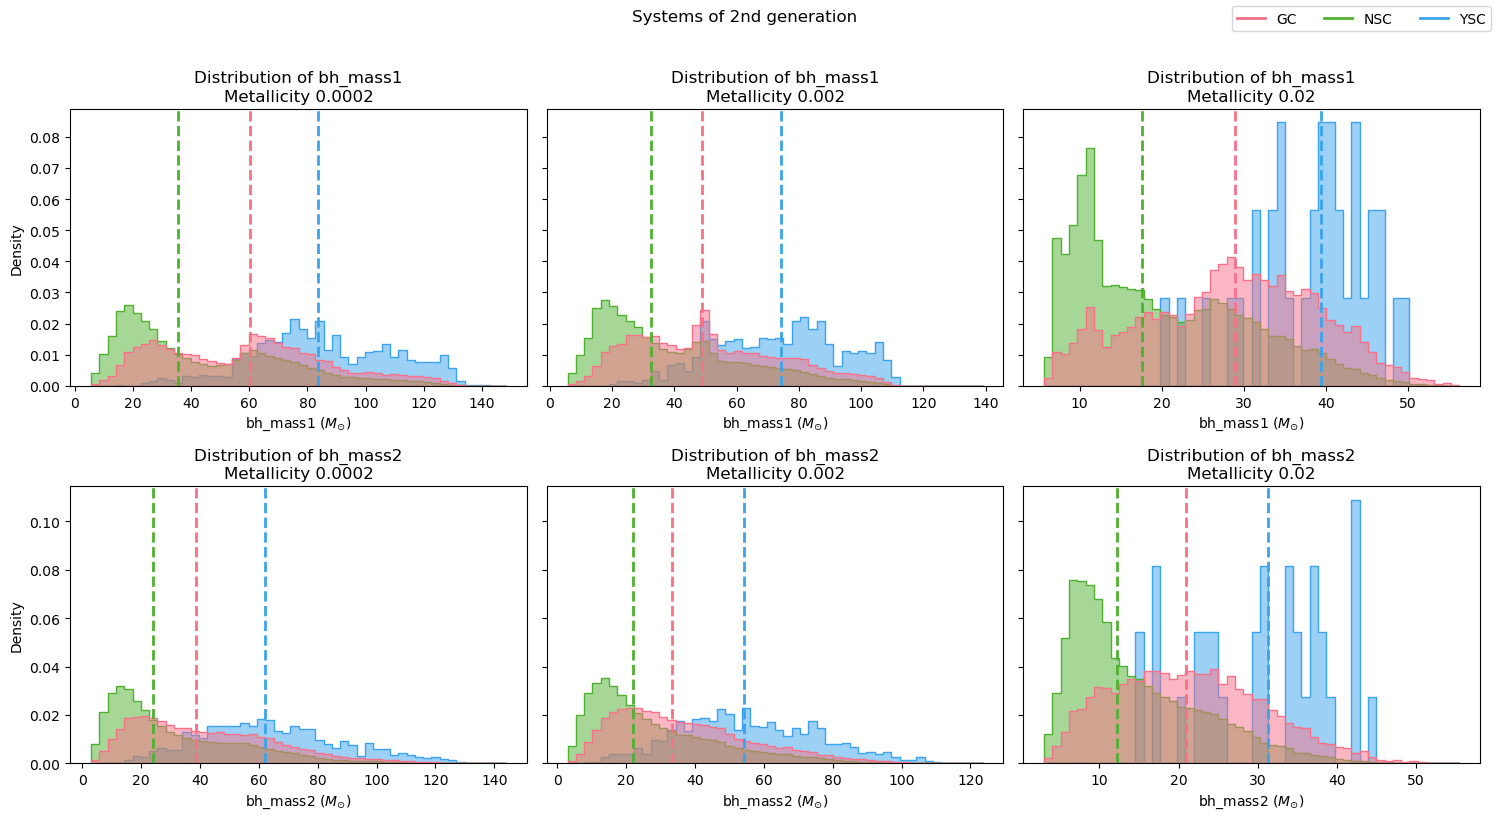

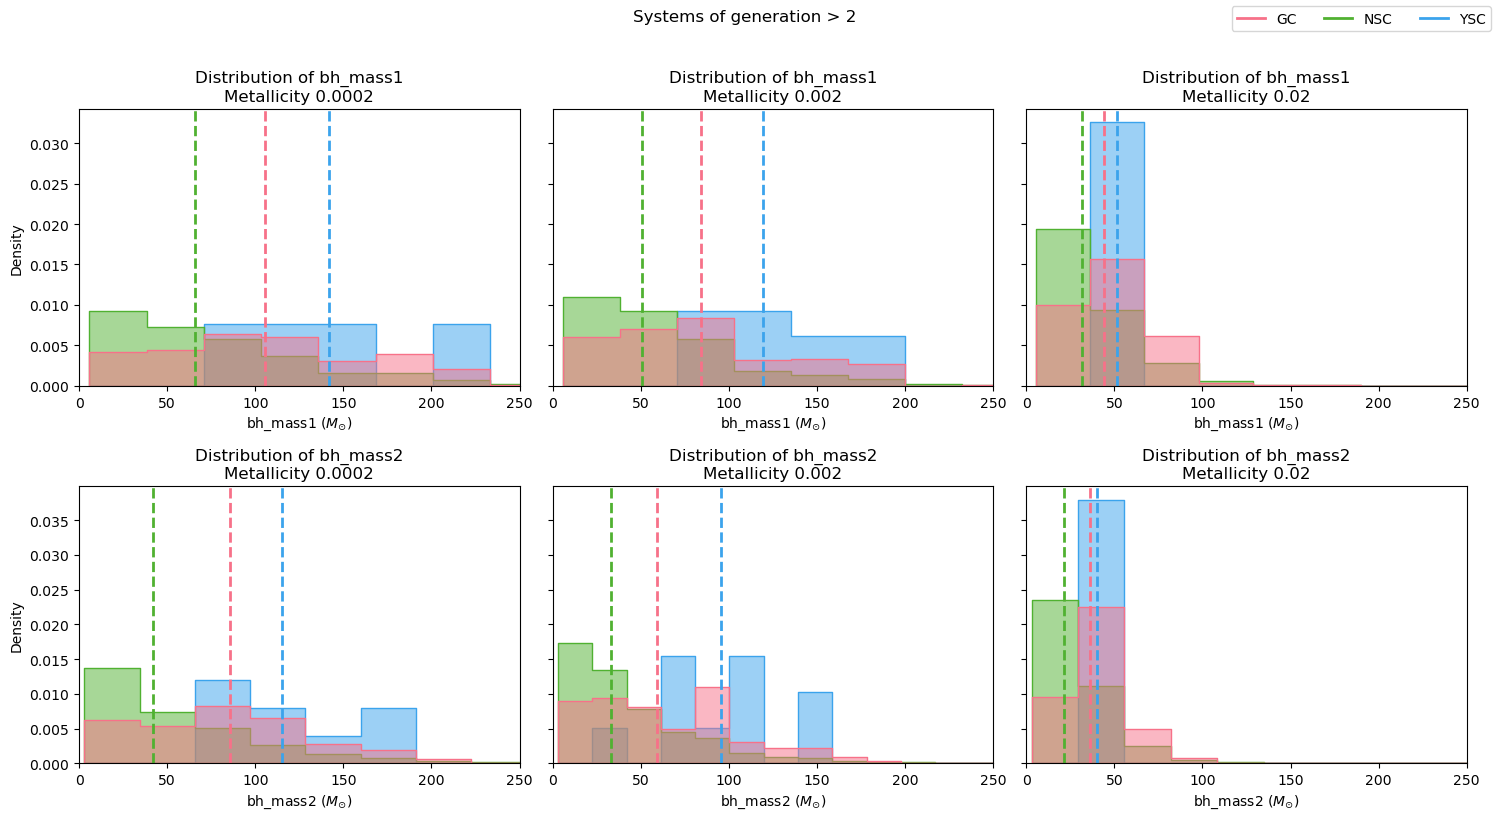

Mean Mass per Cluster (Generation = 2):
 label  mean_mass_bh1  mean_mass_bh2
     1      65.201709      46.307749
     2     117.506453      92.731176
     0      88.254247      67.243431
Mean Mass per Cluster (Generation > 2):
 label  mean_mass_bh1  mean_mass_bh2
     2      51.414220      40.354478
     0      49.976856      39.070659
     1      37.757057      27.628374


In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Specify the metallicities to consider
metallicities = ['0.0002', '0.002', '0.02']

# Create subplots for each metallicity
fig, axes = plt.subplots(2, len(metallicities), figsize=(15, 8), sharey='row')

# Loop through each metallicity and each variable (bh_mass1 and bh_mass2)
for i, met in enumerate(metallicities):
    # Filter the DataFrame for the current metallicity
    df_metallicity = df.filter((df['met'] == float(met)) & (df['label_ngen'] == 0))

    # Create a custom color palette with the necessary number of colors
    custom_palette = sns.color_palette("husl", n_colors=len(df_metallicity['label'].unique()))

    # Plot histogram for bh_mass1
    sns.histplot(data=df_metallicity.to_pandas(), x='bh_mass1', hue='label', bins=50, kde=False, ax=axes[0, i], palette=custom_palette, element="step", stat="density", common_norm=False, alpha=0.5)
    axes[0, i].set_title(f'Distribution of bh_mass1\nMetallicity {met}')
    axes[0, i].set_xlabel(r'bh_mass1 ($M_{\odot}$)')
    axes[0, i].set_ylabel('Density')

    # Plot histogram for bh_mass2
    sns.histplot(data=df_metallicity.to_pandas(), x='bh_mass2', hue='label', bins=50, kde=False, ax=axes[1, i], palette=custom_palette, element="step", stat="density", common_norm=False, alpha=0.5)
    axes[1, i].set_title(f'Distribution of bh_mass2\nMetallicity {met}')
    axes[1, i].set_xlabel(r'bh_mass2 ($M_{\odot}$)')
    axes[1, i].set_ylabel('Density')

    # Add vertical lines for median values in bh_mass1
    for label in df_metallicity['label'].unique():
        median_bh_mass1 = df_metallicity.filter(df_metallicity['label'] == label).to_pandas()['bh_mass1'].median()
        axes[0, i].axvline(median_bh_mass1, color=custom_palette[label], linestyle='dashed', linewidth=2)

    # Add vertical lines for median values in bh_mass2
    for label in df_metallicity['label'].unique():
        median_bh_mass2 = df_metallicity.filter(df_metallicity['label'] == label).to_pandas()['bh_mass2'].median()
        axes[1, i].axvline(median_bh_mass2, color=custom_palette[label], linestyle='dashed', linewidth=2)

    # Remove legend for individual plots
    axes[0, i].legend().set_visible(False)
    axes[1, i].legend().set_visible(False)

# Add a common legend for all subplots
legend_labels = {0: 'GC', 1: 'NSC', 2: 'YSC'}
custom_lines = [Line2D([0], [0], color=custom_palette[i], lw=2, label=legend_labels[i]) for i in legend_labels]
#fig.legend(handles=custom_lines, loc='upper right',ncol=len(legend_labels))
for i, ax in enumerate(axes.flat):
    handles, labels = ax.get_legend_handles_labels()

# Add a common legend outside the loop for the first set of subplots
fig.legend(handles=custom_lines, labels=legend_labels.values(), loc='upper right', ncol=len(legend_labels))


# Add a subtitle for the entire group of subplots
fig.suptitle('Systems of 2nd generation', y=1.02)

# Adjust layout
plt.tight_layout()

# Create subplots for the second generation
fig2, axes2 = plt.subplots(2, len(metallicities), figsize=(15, 8), sharey='row')

# Loop through each metallicity and each variable (bh_mass1 and bh_mass2) for the second generation
for i, met in enumerate(metallicities):
    # Filter the DataFrame for the current metallicity and second generation
    df_metallicity_gen2 = df.filter((df['met'] == float(met)) & (df['label_ngen'] == 1))

    # Create a custom color palette with the necessary number of colors
    custom_palette_gen2 = sns.color_palette("husl", n_colors=len(df_metallicity_gen2['label'].unique()))

    # Plot histogram for bh_mass1
    sns.histplot(data=df_metallicity_gen2.to_pandas(), x='bh_mass1', hue='label', bins=100, kde=False, ax=axes2[0, i], palette=custom_palette_gen2, element="step", stat="density", common_norm=False, alpha=0.5)
    axes2[0, i].set_title(f'Distribution of bh_mass1\nMetallicity {met}')
    axes2[0, i].set_xlabel(r'bh_mass1 ($M_{\odot}$)')
    axes2[0, i].set_ylabel('Density')

    # Plot histogram for bh_mass2
    sns.histplot(data=df_metallicity_gen2.to_pandas(), x='bh_mass2', hue='label', bins=100, kde=False, ax=axes2[1, i], palette=custom_palette_gen2, element="step", stat="density", common_norm=False, alpha=0.5)
    axes2[1, i].set_title(f'Distribution of bh_mass2\nMetallicity {met}')
    axes2[1, i].set_xlabel(r'bh_mass2 ($M_{\odot}$)')
    axes2[1, i].set_ylabel('Density')

    # Add vertical lines for median values in bh_mass1
    for label in df_metallicity_gen2['label'].unique():
        median_bh_mass1_gen2 = df_metallicity_gen2.filter(df_metallicity_gen2['label'] == label).to_pandas()['bh_mass1'].median()
        axes2[0, i].axvline(median_bh_mass1_gen2, color=custom_palette_gen2[label], linestyle='dashed', linewidth=2)

    # Add vertical lines for median values in bh_mass2
    for label in df_metallicity_gen2['label'].unique():
        median_bh_mass2_gen2 = df_metallicity_gen2.filter(df_metallicity_gen2['label'] == label).to_pandas()['bh_mass2'].median()
        axes2[1, i].axvline(median_bh_mass2_gen2, color=custom_palette_gen2[label], linestyle='dashed', linewidth=2)

    # Remove legend for individual plots
    axes2[0, i].legend().set_visible(False)
    axes2[1, i].legend().set_visible(False)

    #Set x-axis limits
    axes2[0, i].set_xlim(0, 250)
    axes2[1, i].set_xlim(0, 250)

# Add a common legend for all subplots for the second generation
#fig2.legend(handles=custom_lines, loc='upper right',ncol=len(legend_labels))
for i, ax in enumerate(axes2.flat):
    handles, labels = ax.get_legend_handles_labels()

# Add a common legend outside the loop for the second set of subplots
fig2.legend(handles=custom_lines, labels=legend_labels.values(), loc='upper right', ncol=len(legend_labels))

# Add a subtitle for the entire group of subplots for the second generation
fig2.suptitle('Systems of generation > 2', y=1.02)

# Adjust layout for the second generation subplots
plt.tight_layout()

# Display both sets of subplots
plt.show()

# Compute the mean mass for primary and secondary bh in each cluster for the second generation
df_gen2 = df.filter(df['label_ngen'] == 1)
mean_mass_per_cluster_gen2 = df_gen2.group_by('label').agg(
    pl.col('bh_mass1').mean().alias('mean_mass_bh1'),
    pl.col('bh_mass2').mean().alias('mean_mass_bh2')
)

# Display the mean mass per cluster for the second generation
print("Mean Mass per Cluster (Generation = 2):")
print(mean_mass_per_cluster_gen2.to_pandas().to_string(index=False))

# Compute the mean mass for primary and secondary bh in each cluster for the second generation
mean_mass_per_cluster_gen2 = df_metallicity_gen2.group_by('label').agg(
    pl.col('bh_mass1').mean().alias('mean_mass_bh1'),
    pl.col('bh_mass2').mean().alias('mean_mass_bh2')
)

# Display the mean mass per cluster for the second generation
print("Mean Mass per Cluster (Generation > 2):")
print(mean_mass_per_cluster_gen2.to_pandas().to_string(index=False))

### Spin distribution

The spin of a BH is a measure of the angular momentum of the progenitor star. Three-body interactions in hierarchical systems can result in spin-flip events, where the orientation of a black hole's spin changes significantly. The conservation of angular momentum plays a crucial role in determining the spins of the resulting black holes after a merger.

The distribution of the dimensionless spins looks similar in NSCs, GCs and YSCs, by construction, because in the simulation the same spin models have been assumed. Most first-generation mergers have precessing spin squeezed toward low values (∼ 0.1 − 0.2), while nth-generation mergers tend to have high values of $\chi_\text{p}$ ∼ 0.7. This creates a sort of spin gap between ∼ 0.3 and ∼ 0.6. 

Different spin magnitudes do not significantly impact the shape of the mass function, the maximum mass and the position of the peak, but they have a strong effect on the number of nth-generation mergers. This effect is particularly important for YSCs and GCs, which have a lower escape velocity than NSCs.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

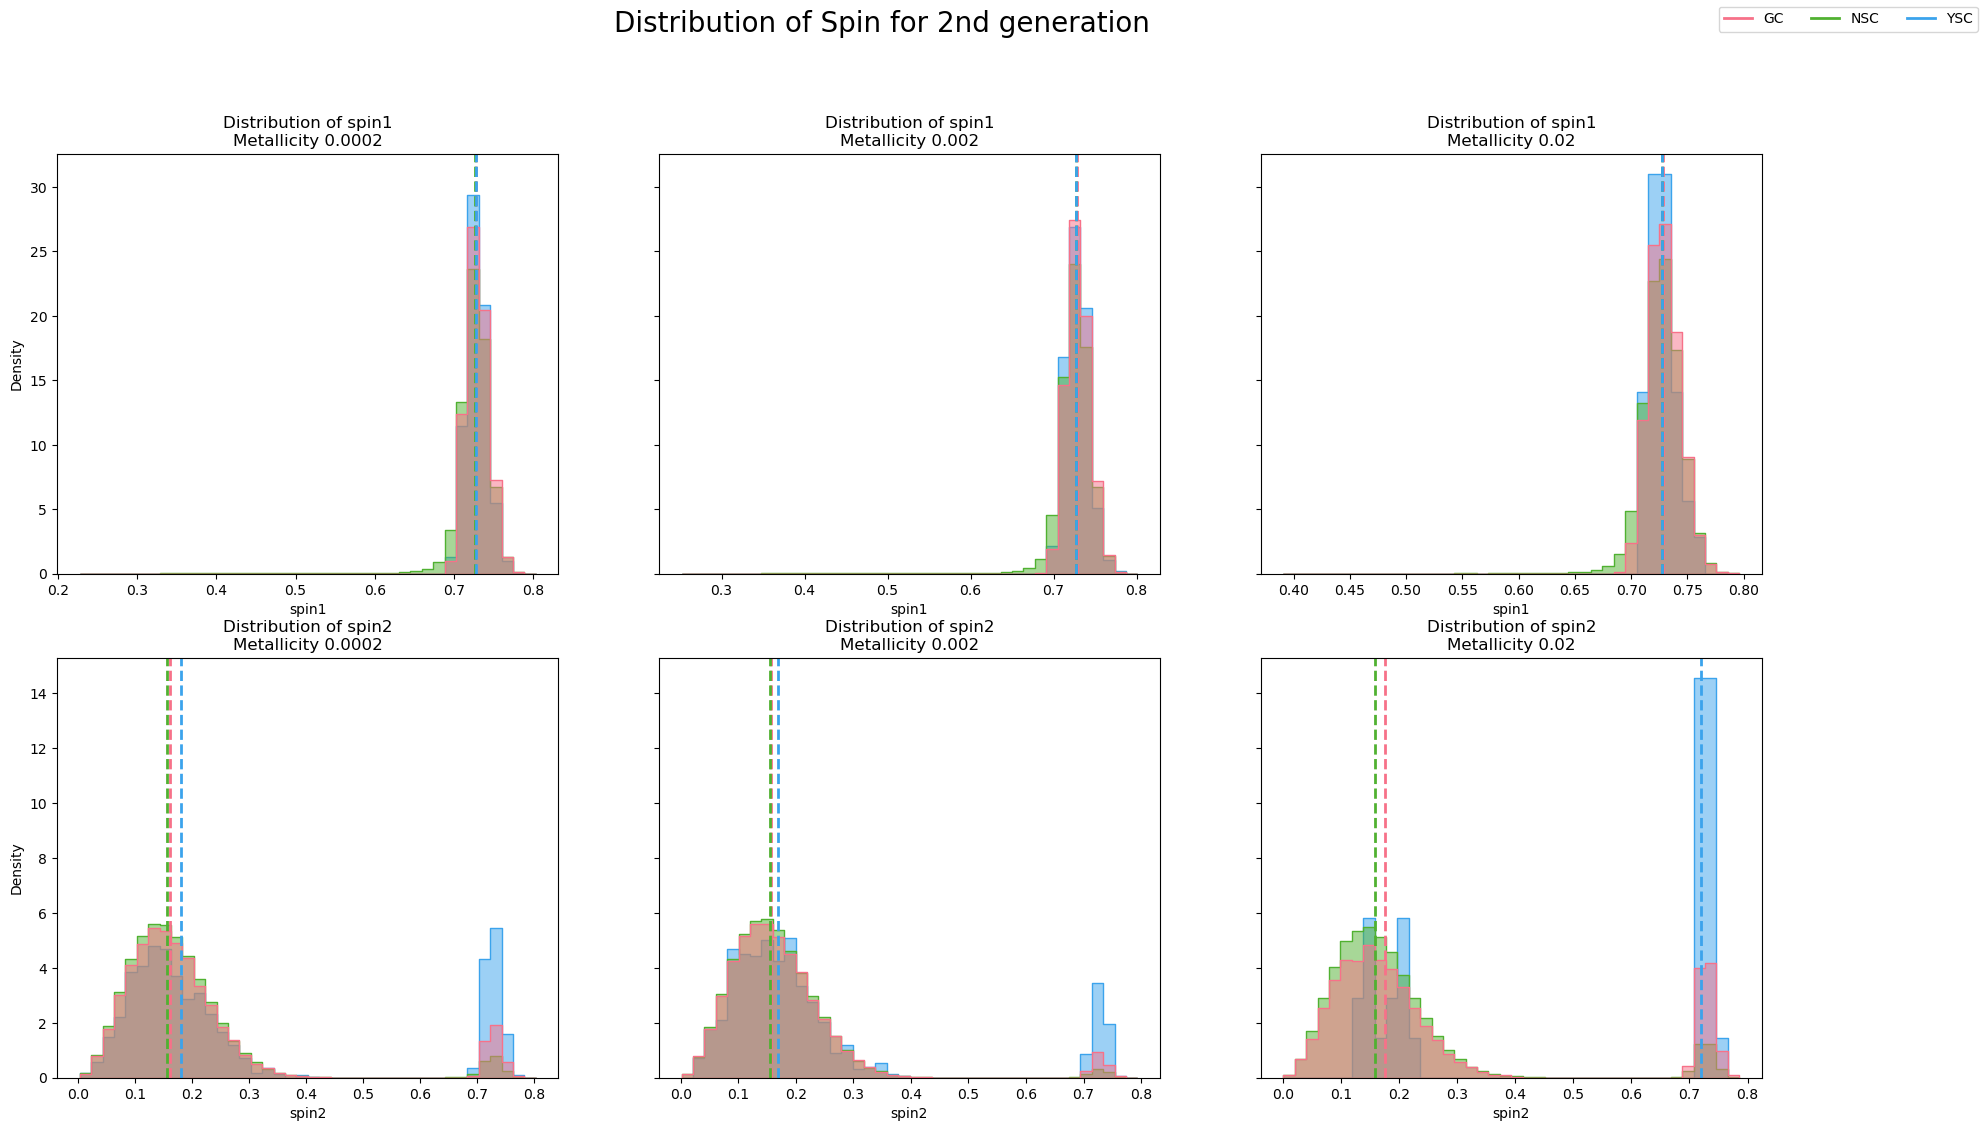

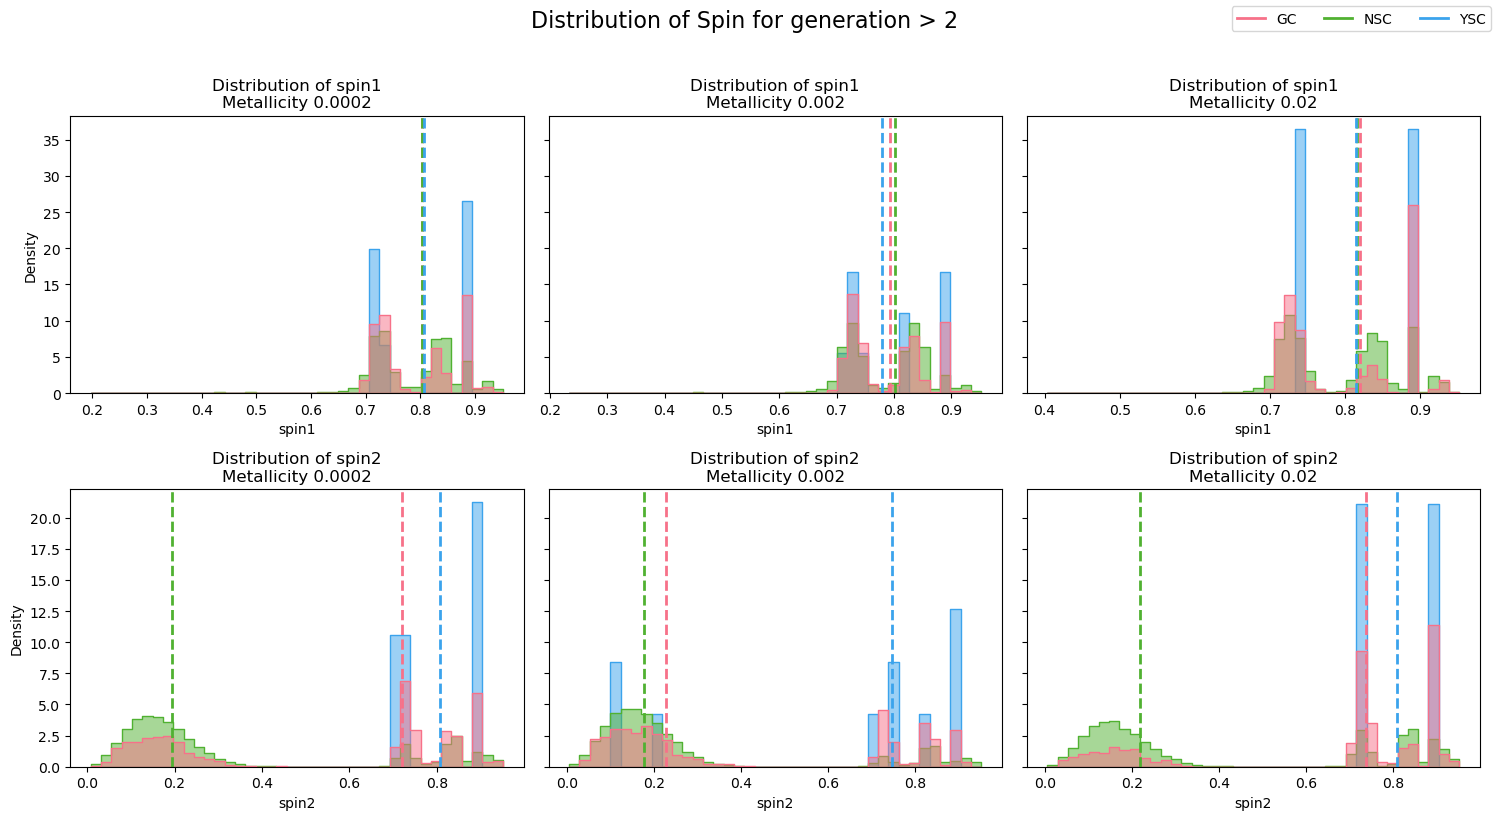

<Figure size 640x480 with 0 Axes>

Mean and Median Spin per Cluster (2nd generation):
 label  mean_spin1  median_spin1  mean_spin2  median_spin2
     0    0.729482      0.728583    0.267517      0.175188
     1    0.726688      0.727343    0.193262      0.158677
     2    0.728731      0.727177    0.507118      0.719911
Mean and Median Spin per Cluster (generation > 2):
 label  mean_spin1  median_spin1  mean_spin2  median_spin2
     0    0.805734      0.819689    0.643407      0.737127
     1    0.795742      0.816409    0.408429      0.219796
     2    0.814856      0.814856    0.809915      0.809915


In [27]:
# Specify the metallicities to consider
metallicities = ['0.0002', '0.002', '0.02']

# Create subplots for each metallicity for 2nd generation
fig, axes = plt.subplots(2, len(metallicities), figsize=(22, 12), sharey='row')

# Create subplots for each metallicity for generation > 2
fig2, axes2 = plt.subplots(2, len(metallicities), figsize=(15, 8), sharey='row')

# Loop through each metallicity and each variable (spin1 and spin2)
for i, met in enumerate(metallicities):
    # Filter the DataFrame for the current metallicity and 2nd generation
    df_metallicity_gen2 = df.filter((df['met'] == float(met)) & (df['label_ngen'] == 0))

    # Create a custom color palette with the necessary number of colors
    custom_palette_gen2 = sns.color_palette("husl", n_colors=len(df_metallicity_gen2['label'].unique()))

    # Plot histogram for spin1 in 2nd generation
    sns.histplot(data=df_metallicity_gen2.to_pandas(), x='spin1', hue='label', bins=40, kde=False, ax=axes[0, i], palette=custom_palette_gen2, element="step", stat="density", common_norm=False, alpha=0.5)
    axes[0, i].set_title(f'Distribution of spin1\nMetallicity {met}')
    axes[0, i].set_xlabel('spin1')
    axes[0, i].set_ylabel('Density')

    # Plot histogram for spin2 in 2nd generation
    sns.histplot(data=df_metallicity_gen2.to_pandas(), x='spin2', hue='label', bins=40, kde=False, ax=axes[1, i], palette=custom_palette_gen2, element="step", stat="density", common_norm=False, alpha=0.5)
    axes[1, i].set_title(f'Distribution of spin2\nMetallicity {met}')
    axes[1, i].set_xlabel('spin2')
    axes[1, i].set_ylabel('Density')

    # Add vertical lines for median values in spin1 for 2nd generation
    for label in df_metallicity_gen2['label'].unique():
        median_spin1_gen2 = df_metallicity_gen2.filter(df_metallicity_gen2['label'] == label).to_pandas()['spin1'].median()
        axes[0, i].axvline(median_spin1_gen2, color=custom_palette_gen2[label], linestyle='dashed', linewidth=2)

    # Add vertical lines for median values in spin2 for 2nd generation
    for label in df_metallicity_gen2['label'].unique():
        median_spin2_gen2 = df_metallicity_gen2.filter(df_metallicity_gen2['label'] == label).to_pandas()['spin2'].median()
        axes[1, i].axvline(median_spin2_gen2, color=custom_palette_gen2[label], linestyle='dashed', linewidth=2)

    # Remove legend for individual plots for 2nd generation
    axes[0, i].legend().set_visible(False)
    axes[1, i].legend().set_visible(False)

    # Filter the DataFrame for the current metallicity and generation > 2
    df_metallicity_gen_gt2 = df.filter((df['met'] == float(met)) & (df['label_ngen'] == 1))

    # Create a custom color palette with the necessary number of colors
    custom_palette_gen_gt2 = sns.color_palette("husl", n_colors=len(df_metallicity_gen_gt2['label'].unique()))

    # Plot histogram for spin1 in generation > 2
    sns.histplot(data=df_metallicity_gen_gt2.to_pandas(), x='spin1', hue='label', bins=40, kde=False, ax=axes2[0, i], palette=custom_palette_gen_gt2, element="step", stat="density", common_norm=False, alpha=0.5)
    axes2[0, i].set_title(f'Distribution of spin1\nMetallicity {met}')
    axes2[0, i].set_xlabel('spin1')
    axes2[0, i].set_ylabel('Density')

    # Plot histogram for spin2 in generation > 2
    sns.histplot(data=df_metallicity_gen_gt2.to_pandas(), x='spin2', hue='label', bins=40, kde=False, ax=axes2[1, i], palette=custom_palette_gen_gt2, element="step", stat="density", common_norm=False, alpha=0.5)
    axes2[1, i].set_title(f'Distribution of spin2\nMetallicity {met}')
    axes2[1, i].set_xlabel('spin2')
    axes2[1, i].set_ylabel('Density')

    # Add vertical lines for median values in spin1 for generation > 2
    for label in df_metallicity_gen_gt2['label'].unique():
        median_spin1_gen_gt2 = df_metallicity_gen_gt2.filter(df_metallicity_gen_gt2['label'] == label).to_pandas()['spin1'].median()
        axes2[0, i].axvline(median_spin1_gen_gt2, color=custom_palette_gen_gt2[label], linestyle='dashed', linewidth=2)

    # Add vertical lines for median values in spin2 for generation > 2
    for label in df_metallicity_gen_gt2['label'].unique():
        median_spin2_gen_gt2 = df_metallicity_gen_gt2.filter(df_metallicity_gen_gt2['label'] == label).to_pandas()['spin2'].median()
        axes2[1, i].axvline(median_spin2_gen_gt2, color=custom_palette_gen_gt2[label], linestyle='dashed', linewidth=2)

    # Remove legend for individual plots for generation > 2
    axes2[0, i].legend().set_visible(False)
    axes2[1, i].legend().set_visible(False)

# Add legend for all subplots for 2nd generation
legend_labels_gen2 = {0: 'GC', 1: 'NSC', 2: 'YSC'}
custom_lines_gen2 = [Line2D([0], [0], color=custom_palette_gen2[i], lw=2, label=legend_labels_gen2[i]) for i in legend_labels_gen2]
fig.legend(handles=custom_lines_gen2, loc='upper right', ncol=len(legend_labels_gen2))

# Add legend for all subplots for generation > 2
legend_labels_gen_gt2 = {0: 'GC', 1: 'NSC', 2: 'YSC'}
custom_lines_gen_gt2 = [Line2D([0], [0], color=custom_palette_gen_gt2[i], lw=2, label=legend_labels_gen_gt2[i]) for i in legend_labels_gen_gt2]
fig2.legend(handles=custom_lines_gen_gt2, loc='upper right', ncol=len(legend_labels_gen_gt2))

# Add a common title for all subplots for 2nd generation
fig.suptitle('Distribution of Spin for 2nd generation', y=1,fontsize=20)

# Add a common title for all subplots for generation > 2
fig2.suptitle('Distribution of Spin for generation > 2', y=1.02,fontsize=16)

# Adjust layout for 2nd generation subplots
plt.tight_layout()
plt.show()

# Adjust layout for generation > 2 subplots
plt.tight_layout()
plt.show()

# Compute the mean and median spin for spin1 and spin2 in each cluster for 2nd generation
mean_median_spin_per_cluster_gen2 = df_metallicity_gen2.group_by('label').agg(
    pl.col('spin1').mean().alias('mean_spin1'),
    pl.col('spin1').median().alias('median_spin1'),
    pl.col('spin2').mean().alias('mean_spin2'),
    pl.col('spin2').median().alias('median_spin2')
)

# Compute the mean and median spin for spin1 and spin2 in each cluster for generation > 2
mean_median_spin_per_cluster_gen_gt2 = df_metallicity_gen_gt2.group_by('label').agg(
    pl.col('spin1').mean().alias('mean_spin1'),
    pl.col('spin1').median().alias('median_spin1'),
    pl.col('spin2').mean().alias('mean_spin2'),
    pl.col('spin2').median().alias('median_spin2')
)

# Display the mean and median spin per cluster for 2nd generation
print("Mean and Median Spin per Cluster (2nd generation):")
print(mean_median_spin_per_cluster_gen2.to_pandas().to_string(index=False))

# Display the mean and median spin per cluster for generation > 2
print("Mean and Median Spin per Cluster (generation > 2):")
print(mean_median_spin_per_cluster_gen_gt2.to_pandas().to_string(index=False))

### Mass of the BH remnant resulting from the merger

The plots show the distribution of remnant masses for 2nd and >2nd-generation systems, categorized by their hosting bodies.

1. **Globular Clusters (GC)**: GC shows a broader distribution for remnant masses at all metallicity levels. This could indicate a wider variety of remnant masses within NSCs, possibly due to the dense stellar environment leading to more frequent and diverse interactions.

2. **Nuclear Star Clusters (NSC)**: NSC, especially at higher metallicity (0.02), exhibits a concentration towards lower remnant masses. This could be due to stellar wind mass loss being more significant in stars with higher metallicity, leading to the formation of less massive remnants.

3. **Young Stellar Clusters (YSC)**: YSC are producing more massive remnants because of the environment's exceptional density.

The mass function of nth-generation BBHs peaks at values ∼ 30 − 100 $M_\odot$ in all considered star clusters. The main difference between NSCs, GCs and YSCs is the maximum mass of nth-generation BBHs.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


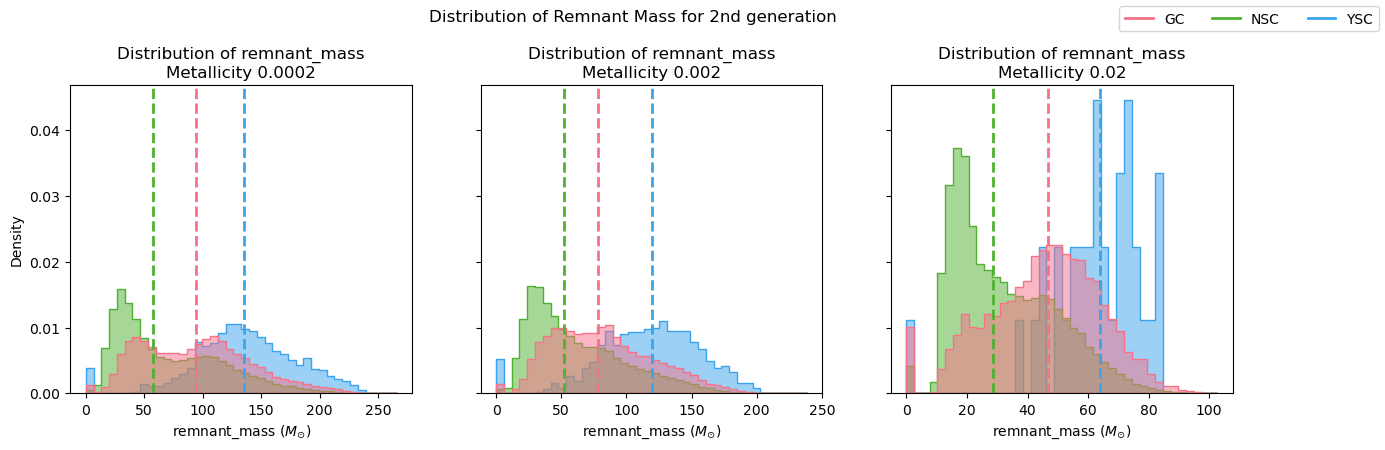

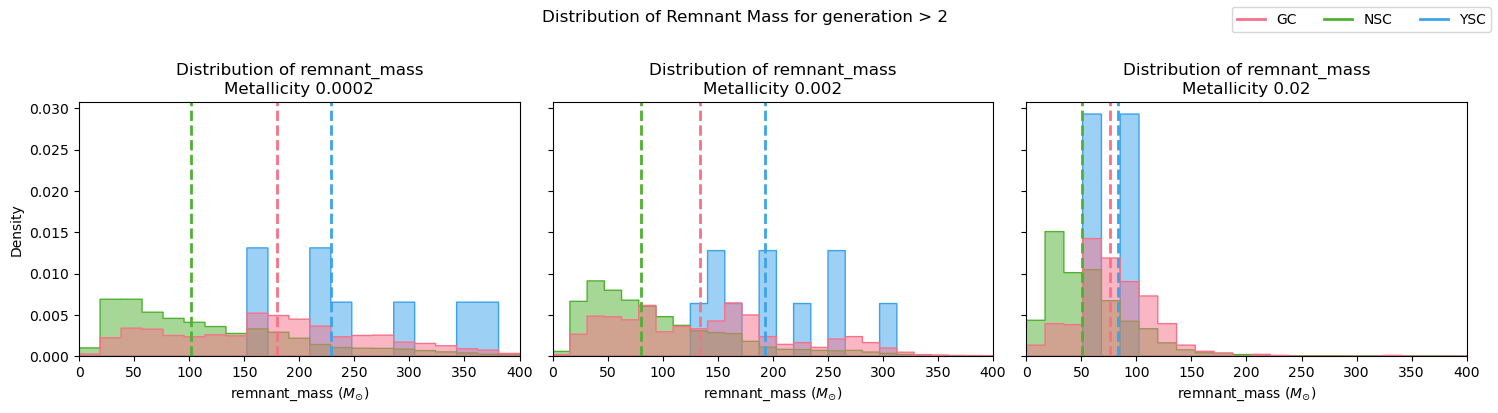

<Figure size 640x480 with 0 Axes>

Mean and Median Remnant Mass per Cluster (2nd generation):
 label  mean_remnant_mass  median_remnant_mass
     0          45.522474            46.816970
     1          32.379188            28.542374
     2          62.485060            64.075715
Mean and Median Remnant Mass per Cluster (generation > 2):
 label  mean_remnant_mass  median_remnant_mass
     0          81.178210            75.586308
     1          59.968964            50.550203
     2          83.523150            83.523150


In [61]:
# Specify the metallicities to consider
metallicities = ['0.0002', '0.002', '0.02']

# Create subplots for each metallicity for 2nd generation
fig, axes = plt.subplots(1, len(metallicities), figsize=(15, 4), sharey='row')

# Create subplots for each metallicity for generation > 2
fig2, axes2 = plt.subplots(1, len(metallicities), figsize=(15, 4), sharey='row')

# Loop through each metallicity for remnant_mass
for i, met in enumerate(metallicities):
    # Filter the DataFrame for the current metallicity and 2nd generation
    df_metallicity_gen2 = df.filter((df['met'] == float(met)) & (df['label_ngen'] == 0))

    # Create a custom color palette with the necessary number of colors
    custom_palette_gen2 = sns.color_palette("husl", n_colors=len(df_metallicity_gen2['label'].unique()))

    # Plot histogram for remnant_mass in 2nd generation
    sns.histplot(data=df_metallicity_gen2.to_pandas(), x='remnant_mass', hue='label', bins=40, kde=False, ax=axes[i], palette=custom_palette_gen2, element="step", stat="density", common_norm=False, alpha=0.5)
    axes[i].set_title(f'Distribution of remnant_mass\nMetallicity {met}')
    axes[i].set_xlabel(r'remnant_mass ($M_{\odot}$)')
    axes[i].set_ylabel('Density')

    # Add vertical lines for median values in remnant_mass for 2nd generation
    for label in df_metallicity_gen2['label'].unique():
        median_rem_mass_gen2 = df_metallicity_gen2.filter(df_metallicity_gen2['label'] == label).to_pandas()['remnant_mass'].median()
        axes[i].axvline(median_rem_mass_gen2, color=custom_palette_gen2[label], linestyle='dashed', linewidth=2)

    # Remove legend for individual plots for 2nd generation
    axes[i].legend().set_visible(False)

    # Filter the DataFrame for the current metallicity and generation > 2
    df_metallicity_gen_gt2 = df.filter((df['met'] == float(met)) & (df['label_ngen'] == 1))

    # Create a custom color palette with the necessary number of colors
    custom_palette_gen_gt2 = sns.color_palette("husl", n_colors=len(df_metallicity_gen_gt2['label'].unique()))

    # Plot histogram for remnant_mass in generation > 2
    sns.histplot(data=df_metallicity_gen_gt2.to_pandas(), x='remnant_mass', hue='label', bins=300, kde=False, ax=axes2[i], palette=custom_palette_gen_gt2, element="step", stat="density", common_norm=False, alpha=0.5)
    axes2[i].set_title(f'Distribution of remnant_mass\nMetallicity {met}')
    axes2[i].set_xlabel(r'remnant_mass ($M_{\odot}$)')
    axes2[i].set_ylabel('Density')

    # Add vertical lines for median values in remnant_mass for generation > 2
    for label in df_metallicity_gen_gt2['label'].unique():
        median_rem_mass_gen_gt2 = df_metallicity_gen_gt2.filter(df_metallicity_gen_gt2['label'] == label).to_pandas()['remnant_mass'].median()
        axes2[i].axvline(median_rem_mass_gen_gt2, color=custom_palette_gen_gt2[label], linestyle='dashed', linewidth=2)

    # Set x-axis limits for generation > 2
    axes2[i].set_xlim([0, 400])

    # Remove legend for individual plots for generation > 2
    axes2[i].legend().set_visible(False)

# Add legend for all subplots for 2nd generation
legend_labels_gen2 = {0: 'GC', 1: 'NSC', 2: 'YSC'}
custom_lines_gen2 = [Line2D([0], [0], color=custom_palette_gen2[i], lw=2, label=legend_labels_gen2[i]) for i in legend_labels_gen2]
fig.legend(handles=custom_lines_gen2, loc='upper right', ncol=len(legend_labels_gen2))

# Add legend for all subplots for generation > 2
legend_labels_gen_gt2 = {0: 'GC', 1: 'NSC', 2: 'YSC'}
custom_lines_gen_gt2 = [Line2D([0], [0], color=custom_palette_gen_gt2[i], lw=2, label=legend_labels_gen_gt2[i]) for i in legend_labels_gen_gt2]
fig2.legend(handles=custom_lines_gen_gt2, loc='upper right', ncol=len(legend_labels_gen_gt2))

# Add a common title for all subplots for 2nd generation
fig.suptitle('Distribution of Remnant Mass for 2nd generation', y=1.07)

# Add a common title for all subplots for generation > 2
fig2.suptitle('Distribution of Remnant Mass for generation > 2', y=1.02)

# Adjust layout for 2nd generation subplots
plt.tight_layout()
plt.show()

# Adjust layout for generation > 2 subplots
plt.tight_layout()
plt.show()

# Compute the mean and median remnant mass for each cluster for 2nd generation
mean_median_rem_mass_per_cluster_gen2 = df_metallicity_gen2.group_by('label').agg(
    pl.col('remnant_mass').mean().alias('mean_remnant_mass'),
    pl.col('remnant_mass').median().alias('median_remnant_mass')
)

# Compute the mean and median remnant mass for each cluster for generation > 2
mean_median_rem_mass_per_cluster_gen_gt2 = df_metallicity_gen_gt2.group_by('label').agg(
    pl.col('remnant_mass').mean().alias('mean_remnant_mass'),
    pl.col('remnant_mass').median().alias('median_remnant_mass')
)

# Display the mean and median remnant mass per cluster for 2nd generation
print("Mean and Median Remnant Mass per Cluster (2nd generation):")
print(mean_median_rem_mass_per_cluster_gen2.to_pandas().to_string(index=False))

# Display the mean and median remnant mass per cluster for generation > 2
print("Mean and Median Remnant Mass per Cluster (generation > 2):")
print(mean_median_rem_mass_per_cluster_gen_gt2.to_pandas().to_string(index=False))

### Spin of BH remnant

In the plot, we show the distribution of the dimensionless spin of the BH remnant for systems of 2nd and >2nd-generation systems, for three different metallicities.

It is clear how the distribution for the three hosting bodies is more or less the same. So, this feature is not useful for distinguishing to which cluster the system belongs. Moreover, if we take a look at the systems of higher generation, it can be seen that the small increase in the values reached is not remarkable in order to interpret if a system has evolved or not.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


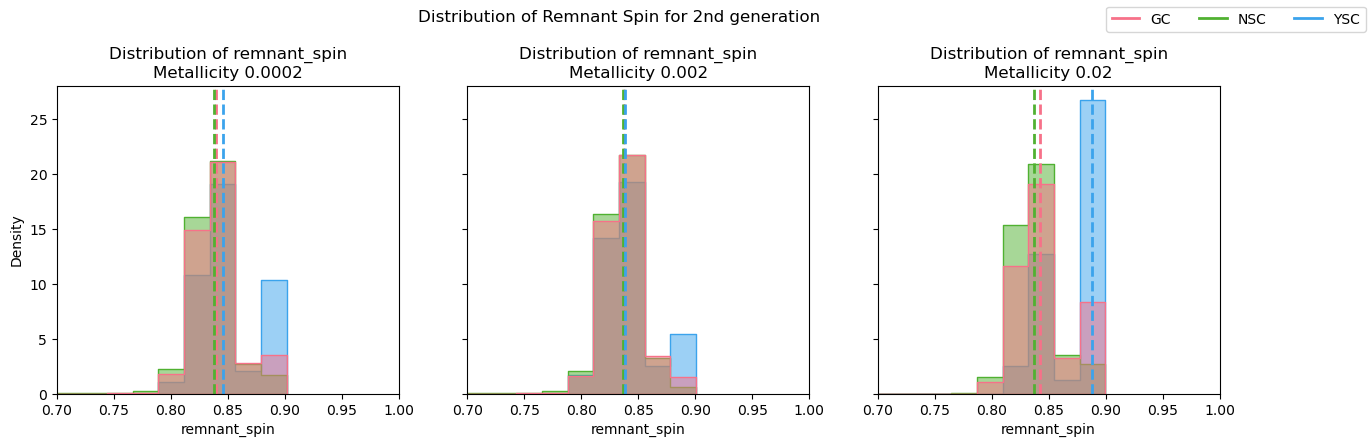

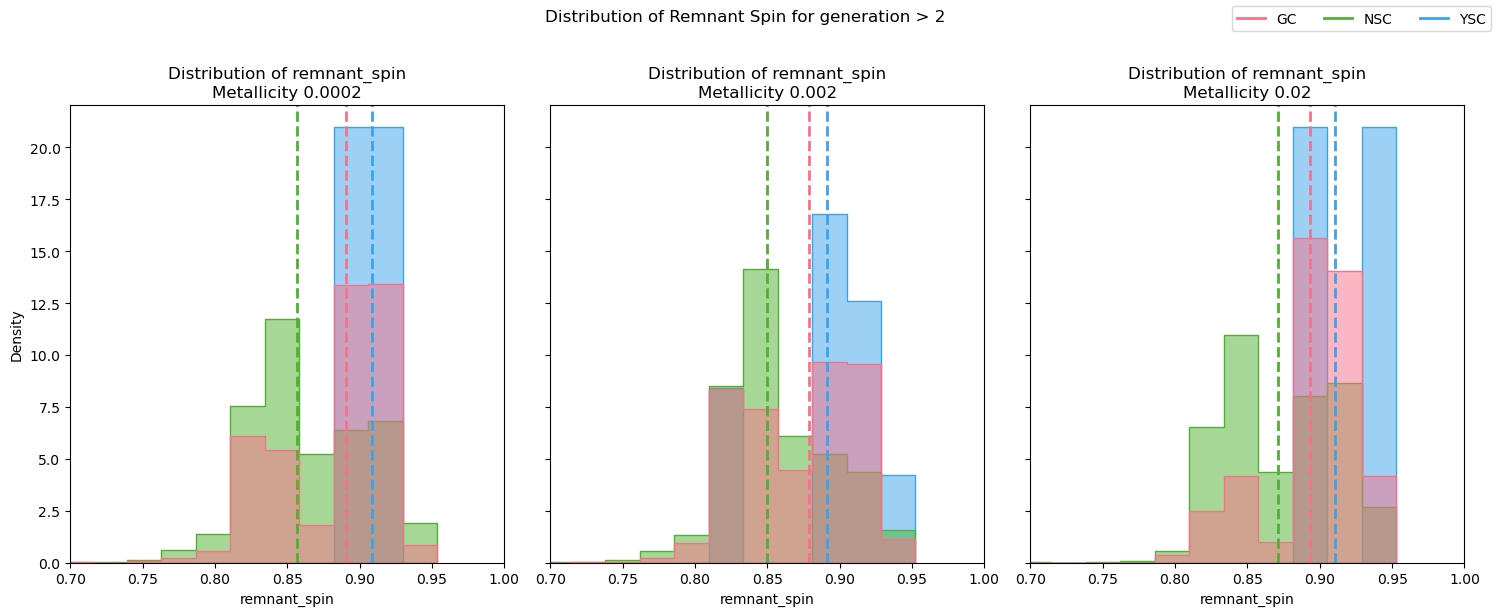

<Figure size 640x480 with 0 Axes>

Mean and Median Remnant Spin per Cluster (2nd generation):
 label  mean_remnant_spin  median_remnant_spin
     0           0.825237             0.842158
     1           0.829919             0.837359
     2           0.847549             0.887764
Mean and Median Remnant Spin per Cluster (generation > 2):
 label  mean_remnant_spin  median_remnant_spin
     0           0.892280             0.893073
     1           0.870723             0.871246
     2           0.910281             0.910281


In [18]:
# Specify the metallicities to consider
metallicities = ['0.0002', '0.002', '0.02']

# Create subplots for each metallicity for 2nd generation
fig, axes = plt.subplots(1, len(metallicities), figsize=(15, 4), sharey='row')

# Create subplots for each metallicity for generation > 2
fig2, axes2 = plt.subplots(1, len(metallicities), figsize=(15, 6), sharey='row')

# Loop through each metallicity and each variable (remnant_spin)
for i, met in enumerate(metallicities):
    # Filter the DataFrame for the current metallicity and 2nd generation
    df_metallicity_gen2 = df.filter((df['met'] == float(met)) & (df['label_ngen'] == 0))

    # Create a custom color palette with the necessary number of colors
    custom_palette_gen2 = sns.color_palette("husl", n_colors=len(df_metallicity_gen2['label'].unique()))

    # Plot histogram for remnant_spin in 2nd generation
    sns.histplot(data=df_metallicity_gen2.to_pandas(), x='remnant_spin', hue='label', bins=40, kde=False, ax=axes[i], palette=custom_palette_gen2, element="step", stat="density", common_norm=False, alpha=0.5)
    axes[i].set_title(f'Distribution of remnant_spin\nMetallicity {met}')
    axes[i].set_xlabel('remnant_spin')
    axes[i].set_ylabel('Density')

    # Add vertical lines for median values in remnant_spin for 2nd generation
    for label in df_metallicity_gen2['label'].unique():
        median_rem_spin_gen2 = df_metallicity_gen2.filter(df_metallicity_gen2['label'] == label).to_pandas()['remnant_spin'].median()
        axes[i].axvline(median_rem_spin_gen2, color=custom_palette_gen2[label], linestyle='dashed', linewidth=2)

    # Remove legend for individual plots for 2nd generation
    axes[i].legend().set_visible(False)

    # Filter the DataFrame for the current metallicity and generation > 2
    df_metallicity_gen_gt2 = df.filter((df['met'] == float(met)) & (df['label_ngen'] == 1))

    # Create a custom color palette with the necessary number of colors
    custom_palette_gen_gt2 = sns.color_palette("husl", n_colors=len(df_metallicity_gen_gt2['label'].unique()))

    # Plot histogram for remnant_spin in generation > 2
    sns.histplot(data=df_metallicity_gen_gt2.to_pandas(), x='remnant_spin', hue='label', bins=40, kde=False, ax=axes2[i], palette=custom_palette_gen_gt2, element="step", stat="density", common_norm=False, alpha=0.5)
    axes2[i].set_title(f'Distribution of remnant_spin\nMetallicity {met}')
    axes2[i].set_xlabel('remnant_spin')
    axes2[i].set_ylabel('Density')

    # Add vertical lines for median values in remnant_spin for generation > 2
    for label in df_metallicity_gen_gt2['label'].unique():
        median_rem_spin_gen_gt2 = df_metallicity_gen_gt2.filter(df_metallicity_gen_gt2['label'] == label).to_pandas()['remnant_spin'].median()
        axes2[i].axvline(median_rem_spin_gen_gt2, color=custom_palette_gen_gt2[label], linestyle='dashed', linewidth=2)

    # Remove legend for individual plots for generation > 2
    axes2[i].legend().set_visible(False)

# Add legend for all subplots for 2nd generation
legend_labels_gen2 = {0: 'GC', 1: 'NSC', 2: 'YSC'}
custom_lines_gen2 = [Line2D([0], [0], color=custom_palette_gen2[i], lw=2, label=legend_labels_gen2[i]) for i in legend_labels_gen2]
fig.legend(handles=custom_lines_gen2, loc='upper right', ncol=len(legend_labels_gen2))

# Add legend for all subplots for generation > 2
legend_labels_gen_gt2 = {0: 'GC', 1: 'NSC', 2: 'YSC'}
custom_lines_gen_gt2 = [Line2D([0], [0], color=custom_palette_gen_gt2[i], lw=2, label=legend_labels_gen_gt2[i]) for i in legend_labels_gen_gt2]
fig2.legend(handles=custom_lines_gen_gt2, loc='upper right', ncol=len(legend_labels_gen_gt2))

# Add a common title for all subplots for 2nd generation
fig.suptitle('Distribution of Remnant Spin for 2nd generation', y=1.07)
#Add limits to x-axis
axes[0].set_xlim([0.7, 1])
axes[1].set_xlim([0.7, 1])
axes[2].set_xlim([0.7, 1])


# Add a common title for all subplots for generation > 2
fig2.suptitle('Distribution of Remnant Spin for generation > 2', y=1.02)
#Add limits to x-axis
axes2[0].set_xlim([0.7, 1])
axes2[1].set_xlim([0.7, 1])
axes2[2].set_xlim([0.7, 1])

# Adjust layout for 2nd generation subplots
plt.tight_layout()
plt.show()

# Adjust layout for generation > 2 subplots
plt.tight_layout()
plt.show()

# Compute the mean and median remnant_spin for each cluster for 2nd generation
mean_median_rem_spin_per_cluster_gen2 = df_metallicity_gen2.group_by('label').agg(
    pl.col('remnant_spin').mean().alias('mean_remnant_spin'),
    pl.col('remnant_spin').median().alias('median_remnant_spin')
)

# Compute the mean and median remnant_spin for each cluster for generation > 2
mean_median_rem_spin_per_cluster_gen_gt2 = df_metallicity_gen_gt2.group_by('label').agg(
    pl.col('remnant_spin').mean().alias('mean_remnant_spin'),
    pl.col('remnant_spin').median().alias('median_remnant_spin')
)

# Display the mean and median remnant_spin per cluster for 2nd generation
print("Mean and Median Remnant Spin per Cluster (2nd generation):")
print(mean_median_rem_spin_per_cluster_gen2.to_pandas().to_string(index=False))

# Display the mean and median remnant_spin per cluster for generation > 2
print("Mean and Median Remnant Spin per Cluster (generation > 2):")
print(mean_median_rem_spin_per_cluster_gen_gt2.to_pandas().to_string(index=False))

### Escape velocity

The **escape velocity** represents a very important feature to distinguish between the different host bodies. In particular, since NSCs are very massive clusters, they are characterized by high values of the escape velocities. GCs reach broader intermediate values, while YSCs have the lowest escape velocities. 

The same trend is found for both the systems of 2nd and >2nd-generation systems.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


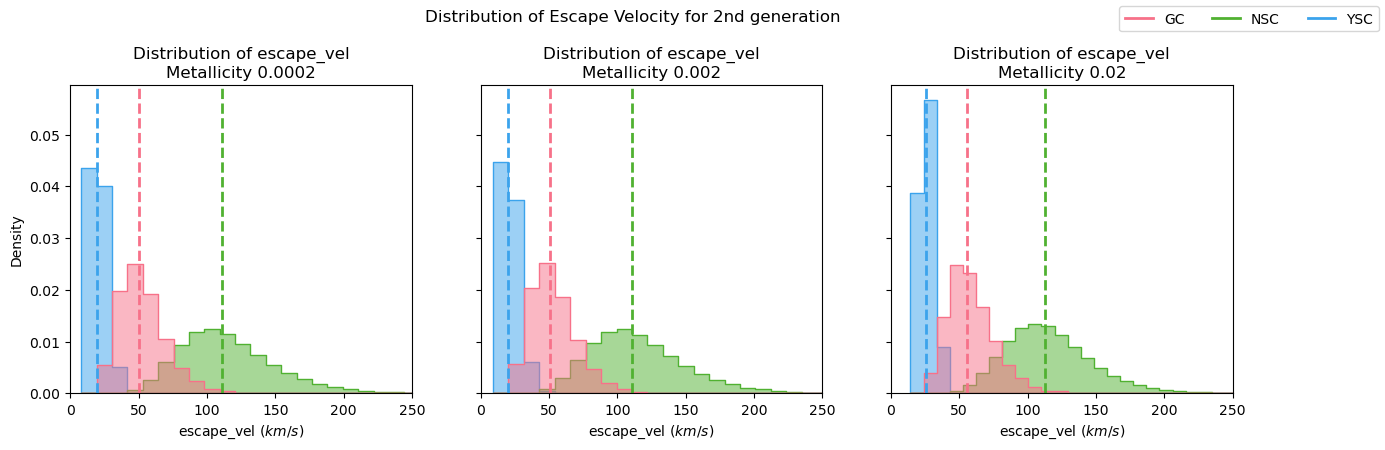

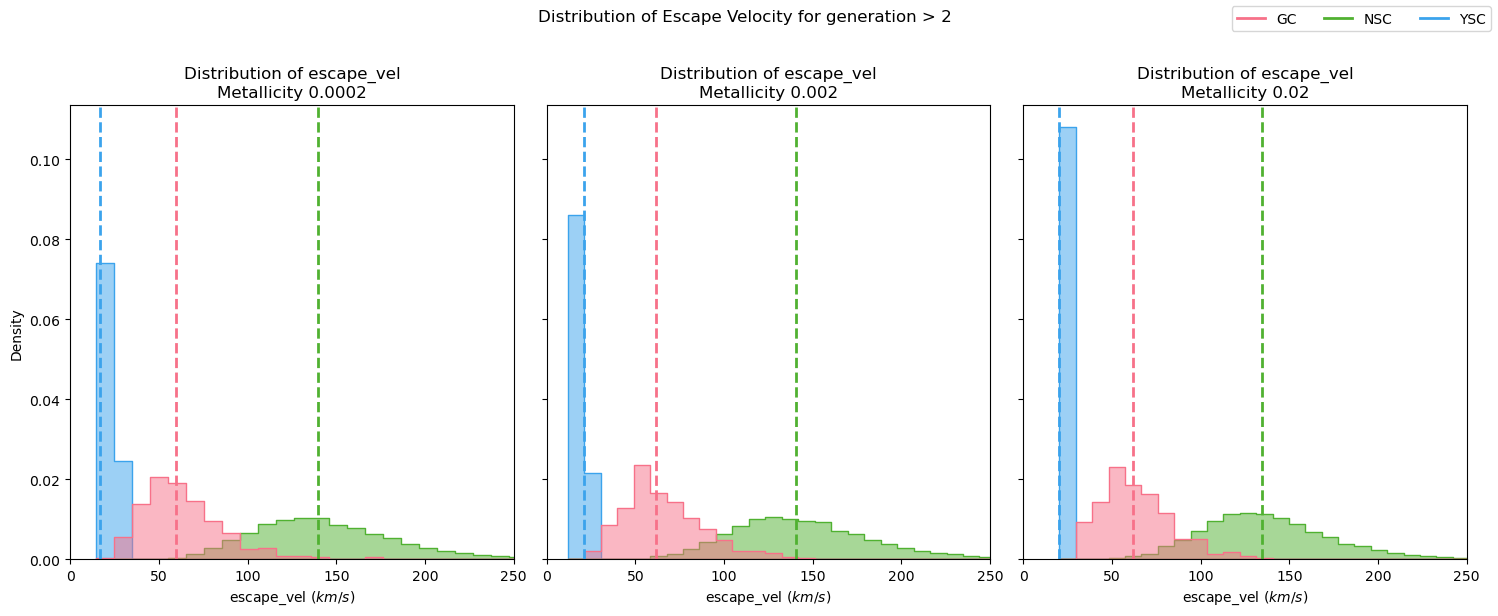

<Figure size 640x480 with 0 Axes>

Mean and Median Escape Velocity per Cluster (2nd generation):
 label  mean_escape_vel  median_escape_vel
     0        58.488560          55.943643
     1       115.890924         112.366910
     2        25.962529          25.749216
Mean and Median Escape Velocity per Cluster (generation > 2):
 label  mean_escape_vel  median_escape_vel
     0        64.096870          61.566995
     1       138.036053         134.331865
     2        20.375570          20.375570


In [12]:
# Specify the metallicities to consider
metallicities = ['0.0002', '0.002', '0.02']

# Create subplots for each metallicity for 2nd generation
fig, axes = plt.subplots(1, len(metallicities), figsize=(15, 4), sharey='row')

# Create subplots for each metallicity for generation > 2
fig2, axes2 = plt.subplots(1, len(metallicities), figsize=(15, 6), sharey='row')

# Loop through each metallicity and each variable (escape_vel)
for i, met in enumerate(metallicities):
    # Filter the DataFrame for the current metallicity and 2nd generation
    df_metallicity_gen2 = df.filter((df['met'] == float(met)) & (df['label_ngen'] == 0))

    # Create a custom color palette with the necessary number of colors
    custom_palette_gen2 = sns.color_palette("husl", n_colors=len(df_metallicity_gen2['label'].unique()))

    # Plot histogram for escape_vel in 2nd generation
    sns.histplot(data=df_metallicity_gen2.to_pandas(), x='escape_vel', hue='label', bins=40, kde=False, ax=axes[i], palette=custom_palette_gen2, element="step", stat="density", common_norm=False, alpha=0.5)
    axes[i].set_title(f'Distribution of escape_vel\nMetallicity {met}')
    axes[i].set_xlabel(r'escape_vel ($km/s$)')
    axes[i].set_ylabel('Density')

    # Add vertical lines for median values in escape_vel for 2nd generation
    for label in df_metallicity_gen2['label'].unique():
        median_escape_vel_gen2 = df_metallicity_gen2.filter(df_metallicity_gen2['label'] == label).to_pandas()['escape_vel'].median()
        axes[i].axvline(median_escape_vel_gen2, color=custom_palette_gen2[label], linestyle='dashed', linewidth=2)

    # Remove legend for individual plots for 2nd generation
    axes[i].legend().set_visible(False)

    # Filter the DataFrame for the current metallicity and generation > 2
    df_metallicity_gen_gt2 = df.filter((df['met'] == float(met)) & (df['label_ngen'] == 1))

    # Create a custom color palette with the necessary number of colors
    custom_palette_gen_gt2 = sns.color_palette("husl", n_colors=len(df_metallicity_gen_gt2['label'].unique()))

    # Plot histogram for escape_vel in generation > 2
    sns.histplot(data=df_metallicity_gen_gt2.to_pandas(), x='escape_vel', hue='label', bins=40, kde=False, ax=axes2[i], palette=custom_palette_gen_gt2, element="step", stat="density", common_norm=False, alpha=0.5)
    axes2[i].set_title(f'Distribution of escape_vel\nMetallicity {met}')
    axes2[i].set_xlabel(r'escape_vel ($km/s$)')
    axes2[i].set_ylabel('Density')

    # Add vertical lines for median values in escape_vel for generation > 2
    for label in df_metallicity_gen_gt2['label'].unique():
        median_escape_vel_gen_gt2 = df_metallicity_gen_gt2.filter(df_metallicity_gen_gt2['label'] == label).to_pandas()['escape_vel'].median()
        axes2[i].axvline(median_escape_vel_gen_gt2, color=custom_palette_gen_gt2[label], linestyle='dashed', linewidth=2)

    # Remove legend for individual plots for generation > 2
    axes2[i].legend().set_visible(False)

# Add legend for all subplots for 2nd generation
legend_labels_gen2 = {0: 'GC', 1: 'NSC', 2: 'YSC'}
custom_lines_gen2 = [Line2D([0], [0], color=custom_palette_gen2[i], lw=2, label=legend_labels_gen2[i]) for i in legend_labels_gen2]
fig.legend(handles=custom_lines_gen2, loc='upper right', ncol=len(legend_labels_gen2))

# Add legend for all subplots for generation > 2
legend_labels_gen_gt2 = {0: 'GC', 1: 'NSC', 2: 'YSC'}
custom_lines_gen_gt2 = [Line2D([0], [0], color=custom_palette_gen_gt2[i], lw=2, label=legend_labels_gen_gt2[i]) for i in legend_labels_gen_gt2]
fig2.legend(handles=custom_lines_gen_gt2, loc='upper right', ncol=len(legend_labels_gen_gt2))

# Add a common title for all subplots for 2nd generation
fig.suptitle('Distribution of Escape Velocity for 2nd generation', y=1.07)
#Add limits to x-axis
axes[0].set_xlim([0, 250])
axes[1].set_xlim([0, 250])
axes[2].set_xlim([0, 250])

# Add a common title for all subplots for generation > 2
fig2.suptitle('Distribution of Escape Velocity for generation > 2', y=1.02)
#Add limits to x-axis
axes2[0].set_xlim([0, 250])
axes2[1].set_xlim([0, 250])
axes2[2].set_xlim([0, 250])

# Adjust layout for 2nd generation subplots
plt.tight_layout()
plt.show()

# Adjust layout for generation > 2 subplots
plt.tight_layout()
plt.show()

# Compute the mean and median escape_vel for each cluster for 2nd generation
mean_median_esc_vel_per_cluster_gen2 = df_metallicity_gen2.group_by('label').agg(
    pl.col('escape_vel').mean().alias('mean_escape_vel'),
    pl.col('escape_vel').median().alias('median_escape_vel')
)

# Compute the mean and median escape_vel for each cluster for generation > 2
mean_median_esc_vel_per_cluster_gen_gt2 = df_metallicity_gen_gt2.group_by('label').agg(
    pl.col('escape_vel').mean().alias('mean_escape_vel'),
    pl.col('escape_vel').median().alias('median_escape_vel')
)

# Display the mean and median escape_vel per cluster for 2nd generation
print("Mean and Median Escape Velocity per Cluster (2nd generation):")
print(mean_median_esc_vel_per_cluster_gen2.to_pandas().to_string(index=False))

# Display the mean and median escape_vel per cluster for generation > 2
print("Mean and Median Escape Velocity per Cluster (generation > 2):")
print(mean_median_esc_vel_per_cluster_gen_gt2.to_pandas().to_string(index=False))

### Total mass of the stellar cluster

The following plots show the distribution of the total mass of the cluster. The more massive clusters considered are the NSCs, reaching $10^7 M_\odot$. YSCs and GCs assest around lower values of the order of $10^7 M_\odot$.

The trend remains the same for both systems of 2nd and >2nd generation.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


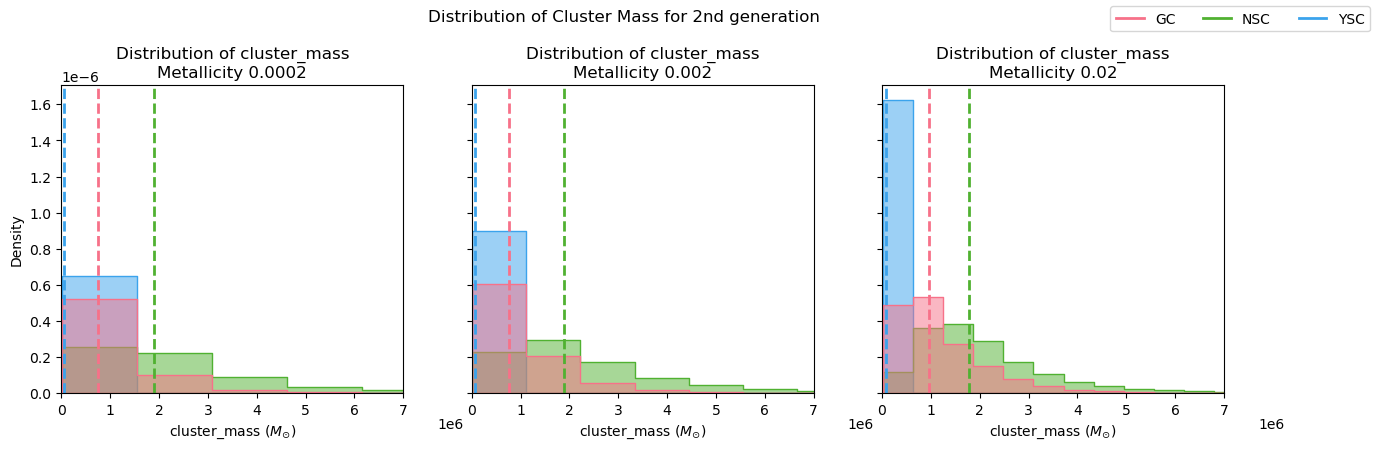

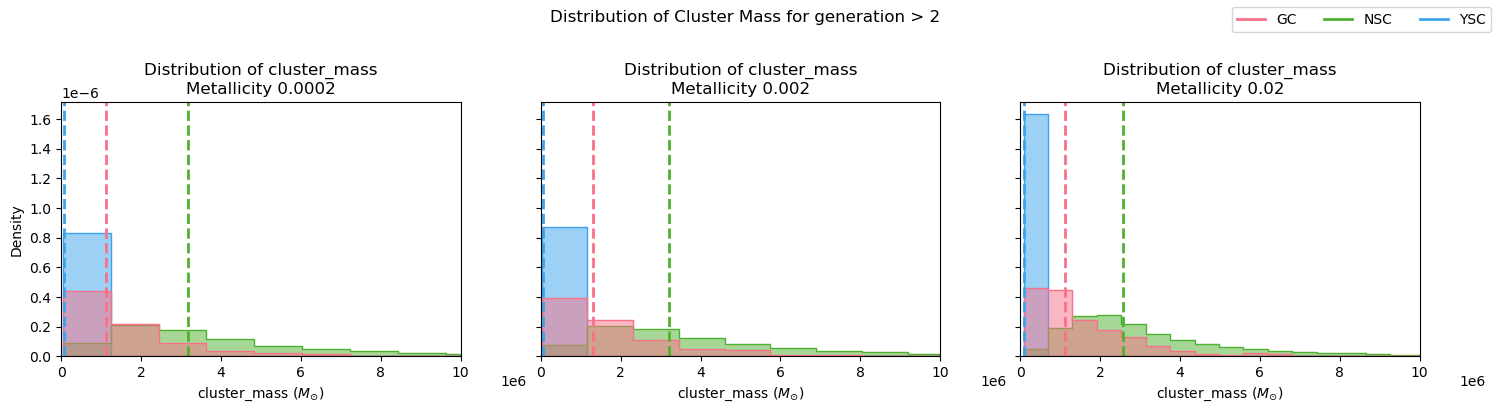

<Figure size 640x480 with 0 Axes>

Mean and Median Cluster Mass per Cluster (2nd generation):
 label  mean_cluster_mass  median_cluster_mass
     0       1.255951e+06         9.643407e+05
     1       2.140616e+06         1.776874e+06
     2       1.315797e+05         7.686096e+04
Mean and Median Cluster Mass per Cluster (generation > 2):
 label  mean_cluster_mass  median_cluster_mass
     0       1.555728e+06         1.120024e+06
     1       3.215869e+06         2.574248e+06
     2       8.108259e+04         8.108259e+04


In [17]:
from matplotlib.lines import Line2D
from matplotlib.ticker import FuncFormatter

# Function to format the x-axis labels to be in the order of 10^6
def format_func(value, tick_number):
    return "{:.0e}".format(value)

# Specify the metallicities to consider
metallicities = ['0.0002', '0.002', '0.02']

# Create subplots for each metallicity for 2nd generation
fig, axes = plt.subplots(1, len(metallicities), figsize=(15, 4), sharey='row')

# Create subplots for each metallicity for generation > 2
fig2, axes2 = plt.subplots(1, len(metallicities), figsize=(15, 4), sharey='row')

# Loop through each metallicity and each variable (cluster_mass)
for i, met in enumerate(metallicities):
    # Filter the DataFrame for the current metallicity and 2nd generation
    df_metallicity_gen2 = df.filter((df['met'] == float(met)) & (df['label_ngen'] == 0))

    # Create a custom color palette with the necessary number of colors
    custom_palette_gen2 = sns.color_palette("husl", n_colors=len(df_metallicity_gen2['label'].unique()))

    # Plot histogram for cluster_mass in 2nd generation
    sns.histplot(data=df_metallicity_gen2.to_pandas(), x='cluster_mass', hue='label', bins=40, kde=False, ax=axes[i], palette=custom_palette_gen2, element="step", stat="density", common_norm=False, alpha=0.5)
    axes[i].set_title(f'Distribution of cluster_mass\nMetallicity {met}')
    axes[i].set_xlabel(r'cluster_mass ($M_{\odot}$)')
    axes[i].set_ylabel('Density')

    # Add vertical lines for median values in cluster_mass for 2nd generation
    for label in df_metallicity_gen2['label'].unique():
        median_cluster_mass_gen2 = df_metallicity_gen2.filter(df_metallicity_gen2['label'] == label).to_pandas()['cluster_mass'].median()
        axes[i].axvline(median_cluster_mass_gen2, color=custom_palette_gen2[label], linestyle='dashed', linewidth=2)

    # Remove legend for individual plots for 2nd generation
    axes[i].legend().set_visible(False)

    # Apply the x-axis label formatting for 2nd generation
    axes[i].xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x / 1e6)))

    # Set x-axis limits for 2nd generation
    #axes[i].set_xlim(0, 2e7)
    axes[i].set_xlim([0, 7e6])

     # Add text annotation for order of magnitude in generation > 2
    axes[i].annotate("1e6", xy=(1.1, -0.1), xycoords="axes fraction", ha="left", va="center", fontsize=10)

    # Filter the DataFrame for the current metallicity and generation > 2
    df_metallicity_gen_gt2 = df.filter((df['met'] == float(met)) & (df['label_ngen'] == 1))

    # Create a custom color palette with the necessary number of colors
    custom_palette_gen_gt2 = sns.color_palette("husl", n_colors=len(df_metallicity_gen_gt2['label'].unique()))

    # Plot histogram for cluster_mass in generation > 2
    sns.histplot(data=df_metallicity_gen_gt2.to_pandas(), x='cluster_mass', hue='label', bins=40, kde=False, ax=axes2[i], palette=custom_palette_gen_gt2, element="step", stat="density", common_norm=False, alpha=0.5)
    axes2[i].set_title(f'Distribution of cluster_mass\nMetallicity {met}')
    axes2[i].set_xlabel(r'cluster_mass ($M_{\odot}$)')
    axes2[i].set_ylabel('Density')

    # Add vertical lines for median values in cluster_mass for generation > 2
    for label in df_metallicity_gen_gt2['label'].unique():
        median_cluster_mass_gen_gt2 = df_metallicity_gen_gt2.filter(df_metallicity_gen_gt2['label'] == label).to_pandas()['cluster_mass'].median()
        axes2[i].axvline(median_cluster_mass_gen_gt2, color=custom_palette_gen_gt2[label], linestyle='dashed', linewidth=2)

    # Remove legend for individual plots for generation > 2
    axes2[i].legend().set_visible(False)

    # Apply the x-axis label formatting for generation > 2
    axes2[i].xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x / 1e6)))

    # Set x-axis limits for generation > 2
    axes2[i].set_xlim(0, 1e7)

    # Add text annotation for order of magnitude in generation > 2
    axes2[i].annotate("1e6", xy=(1.1, -0.1), xycoords="axes fraction", ha="left", va="center", fontsize=10)

# Add legend for all subplots for 2nd generation
legend_labels_gen2 = {0: 'GC', 1: 'NSC', 2: 'YSC'}
custom_lines_gen2 = [Line2D([0], [0], color=custom_palette_gen2[i], lw=2, label=legend_labels_gen2[i]) for i in legend_labels_gen2]
fig.legend(handles=custom_lines_gen2, loc='upper right', ncol=len(legend_labels_gen2))

# Add legend for all subplots for generation > 2
legend_labels_gen_gt2 = {0: 'GC', 1: 'NSC', 2: 'YSC'}
custom_lines_gen_gt2 = [Line2D([0], [0], color=custom_palette_gen_gt2[i], lw=2, label=legend_labels_gen_gt2[i]) for i in legend_labels_gen_gt2]
fig2.legend(handles=custom_lines_gen_gt2, loc='upper right', ncol=len(legend_labels_gen_gt2))

# Add a common title for all subplots for 2nd generation
fig.suptitle('Distribution of Cluster Mass for 2nd generation', y=1.07)

# Add a common title for all subplots for generation > 2
fig2.suptitle('Distribution of Cluster Mass for generation > 2', y=1.02)

# Adjust layout for 2nd generation subplots
plt.tight_layout()
plt.show()

# Adjust layout for generation > 2 subplots
plt.tight_layout()
plt.show()

# Compute the mean and median cluster_mass for each cluster for 2nd generation
mean_median_cluster_mass_per_cluster_gen2 = df_metallicity_gen2.group_by('label').agg(
    pl.col('cluster_mass').mean().alias('mean_cluster_mass'),
    pl.col('cluster_mass').median().alias('median_cluster_mass')
)

# Compute the mean and median cluster_mass for each cluster for generation > 2
mean_median_cluster_mass_per_cluster_gen_gt2 = df_metallicity_gen_gt2.group_by('label').agg(
    pl.col('cluster_mass').mean().alias('mean_cluster_mass'),
    pl.col('cluster_mass').median().alias('median_cluster_mass')
)

# Display the mean and median cluster_mass per cluster for 2nd generation
print("Mean and Median Cluster Mass per Cluster (2nd generation):")
print(mean_median_cluster_mass_per_cluster_gen2.to_pandas().to_string(index=False))

# Display the mean and median cluster_mass per cluster for generation > 2
print("Mean and Median Cluster Mass per Cluster (generation > 2):")
print(mean_median_cluster_mass_per_cluster_gen_gt2.to_pandas().to_string(index=False))


### N° of generation per hosting body

NSCs, because of their high escape velocity, allow a larger number of generations to form, up to primary masses in excess of ∼ $10^3 M_\odot$. The main limitation to build even more massive BHs in NSCs is represented by the long timescales: after ≈ 10 generations at most, the simulation reaches the Hubble time. In contrast, the maximum masses in both GCs and YSCs are
a few times $10^2 M_\odot$. Another crucial difference between NSCs and either GCs or YSCs is the fraction of nth- to first-generation mergers.

NSCs host up to 10 generations in the fiducial case (and up to 17 in the most optimistic case), while GCs and YSCs typically witness up to 4 − 5 and 3 − 4 generations, respectively.
In our case, GCs reach the 5th generation, while YSCs stop at the 3rd generation. This can be seen in a clear way thanks to the zooms on the distribution.

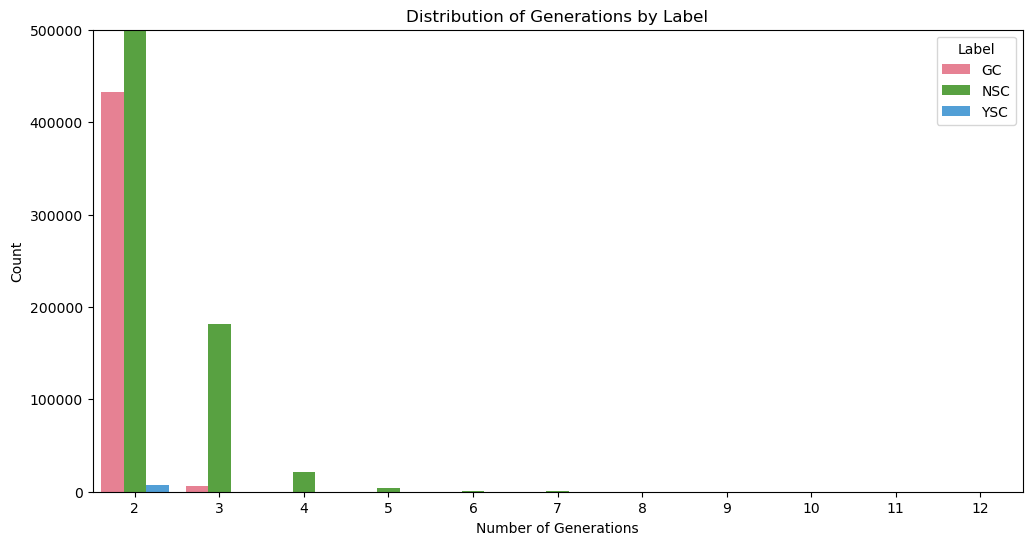

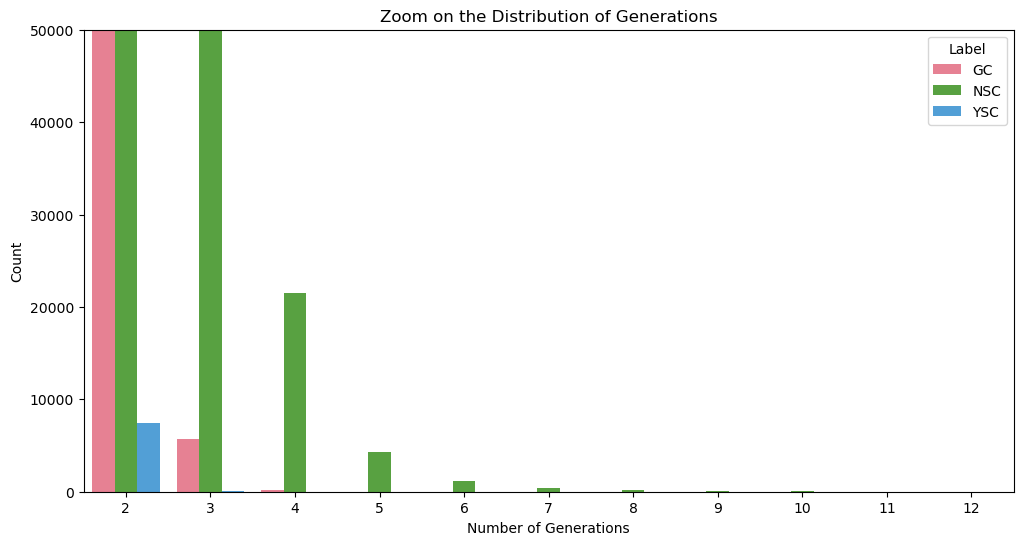

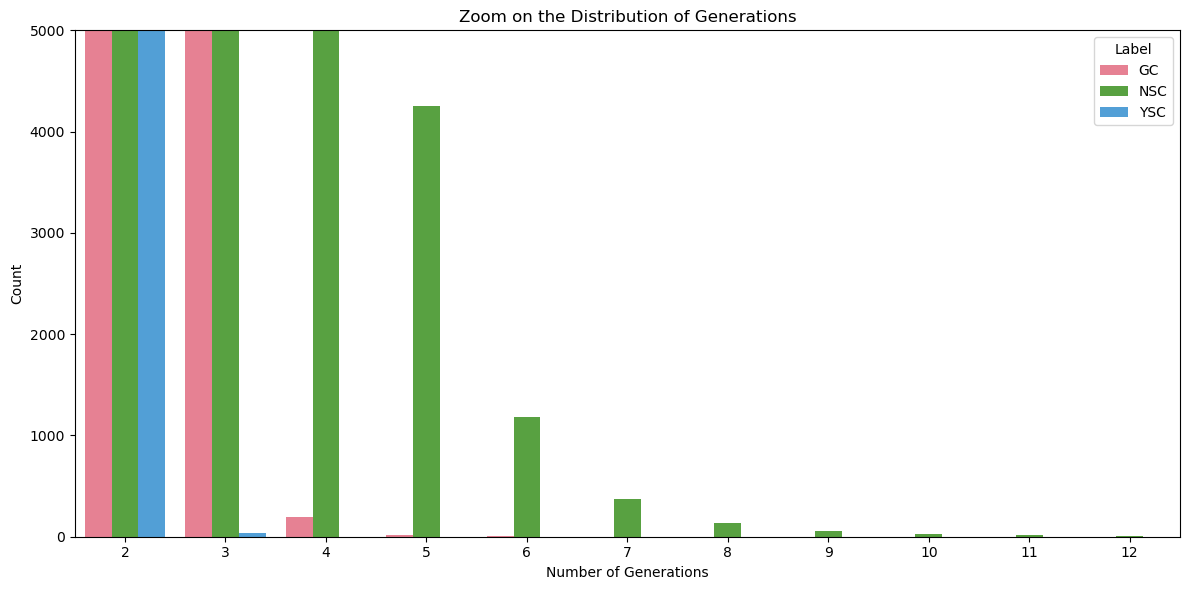

In [12]:
# Define custom label mapping
label_mapping = {0: 'GC', 1: 'NSC', 2: 'YSC'}

# Create the first countplot with custom labels
plt.figure(figsize=(12, 6))
ax1 = sns.countplot(data=df.to_pandas(), x='n_gen', hue='label', palette='husl')
ax1.set_xlabel('Number of Generations')
ax1.set_ylabel('Count')
ax1.set_title('Distribution of Generations by Label')
ax1.legend(title='Label', labels=label_mapping.values())


# Create the second countplot
plt.figure(figsize=(12, 6))
ax2 = sns.countplot(data=df.to_pandas(), x='n_gen', hue='label', palette='husl')
ax2.set_xlabel('Number of Generations')
ax2.set_ylabel('Count')
ax2.set_title('Zoom on the Distribution of Generations')
ax2.legend(title='Label', labels=label_mapping.values())

# Create the third countplot
plt.figure(figsize=(12, 6))
ax3 = sns.countplot(data=df.to_pandas(), x='n_gen', hue='label', palette='husl')
ax3.set_xlabel('Number of Generations')
ax3.set_ylabel('Count')
ax3.set_title('Zoom on the Distribution of Generations')
ax3.legend(title='Label', labels=label_mapping.values())

# Zoom in on the region 
ax1.set_ylim(0, 0.5e6)
ax2.set_ylim(0, 50_000)
ax3.set_ylim(0, 5_000)

# Show both plots
plt.tight_layout()
plt.show()

### BH Mass VS Escape Vel

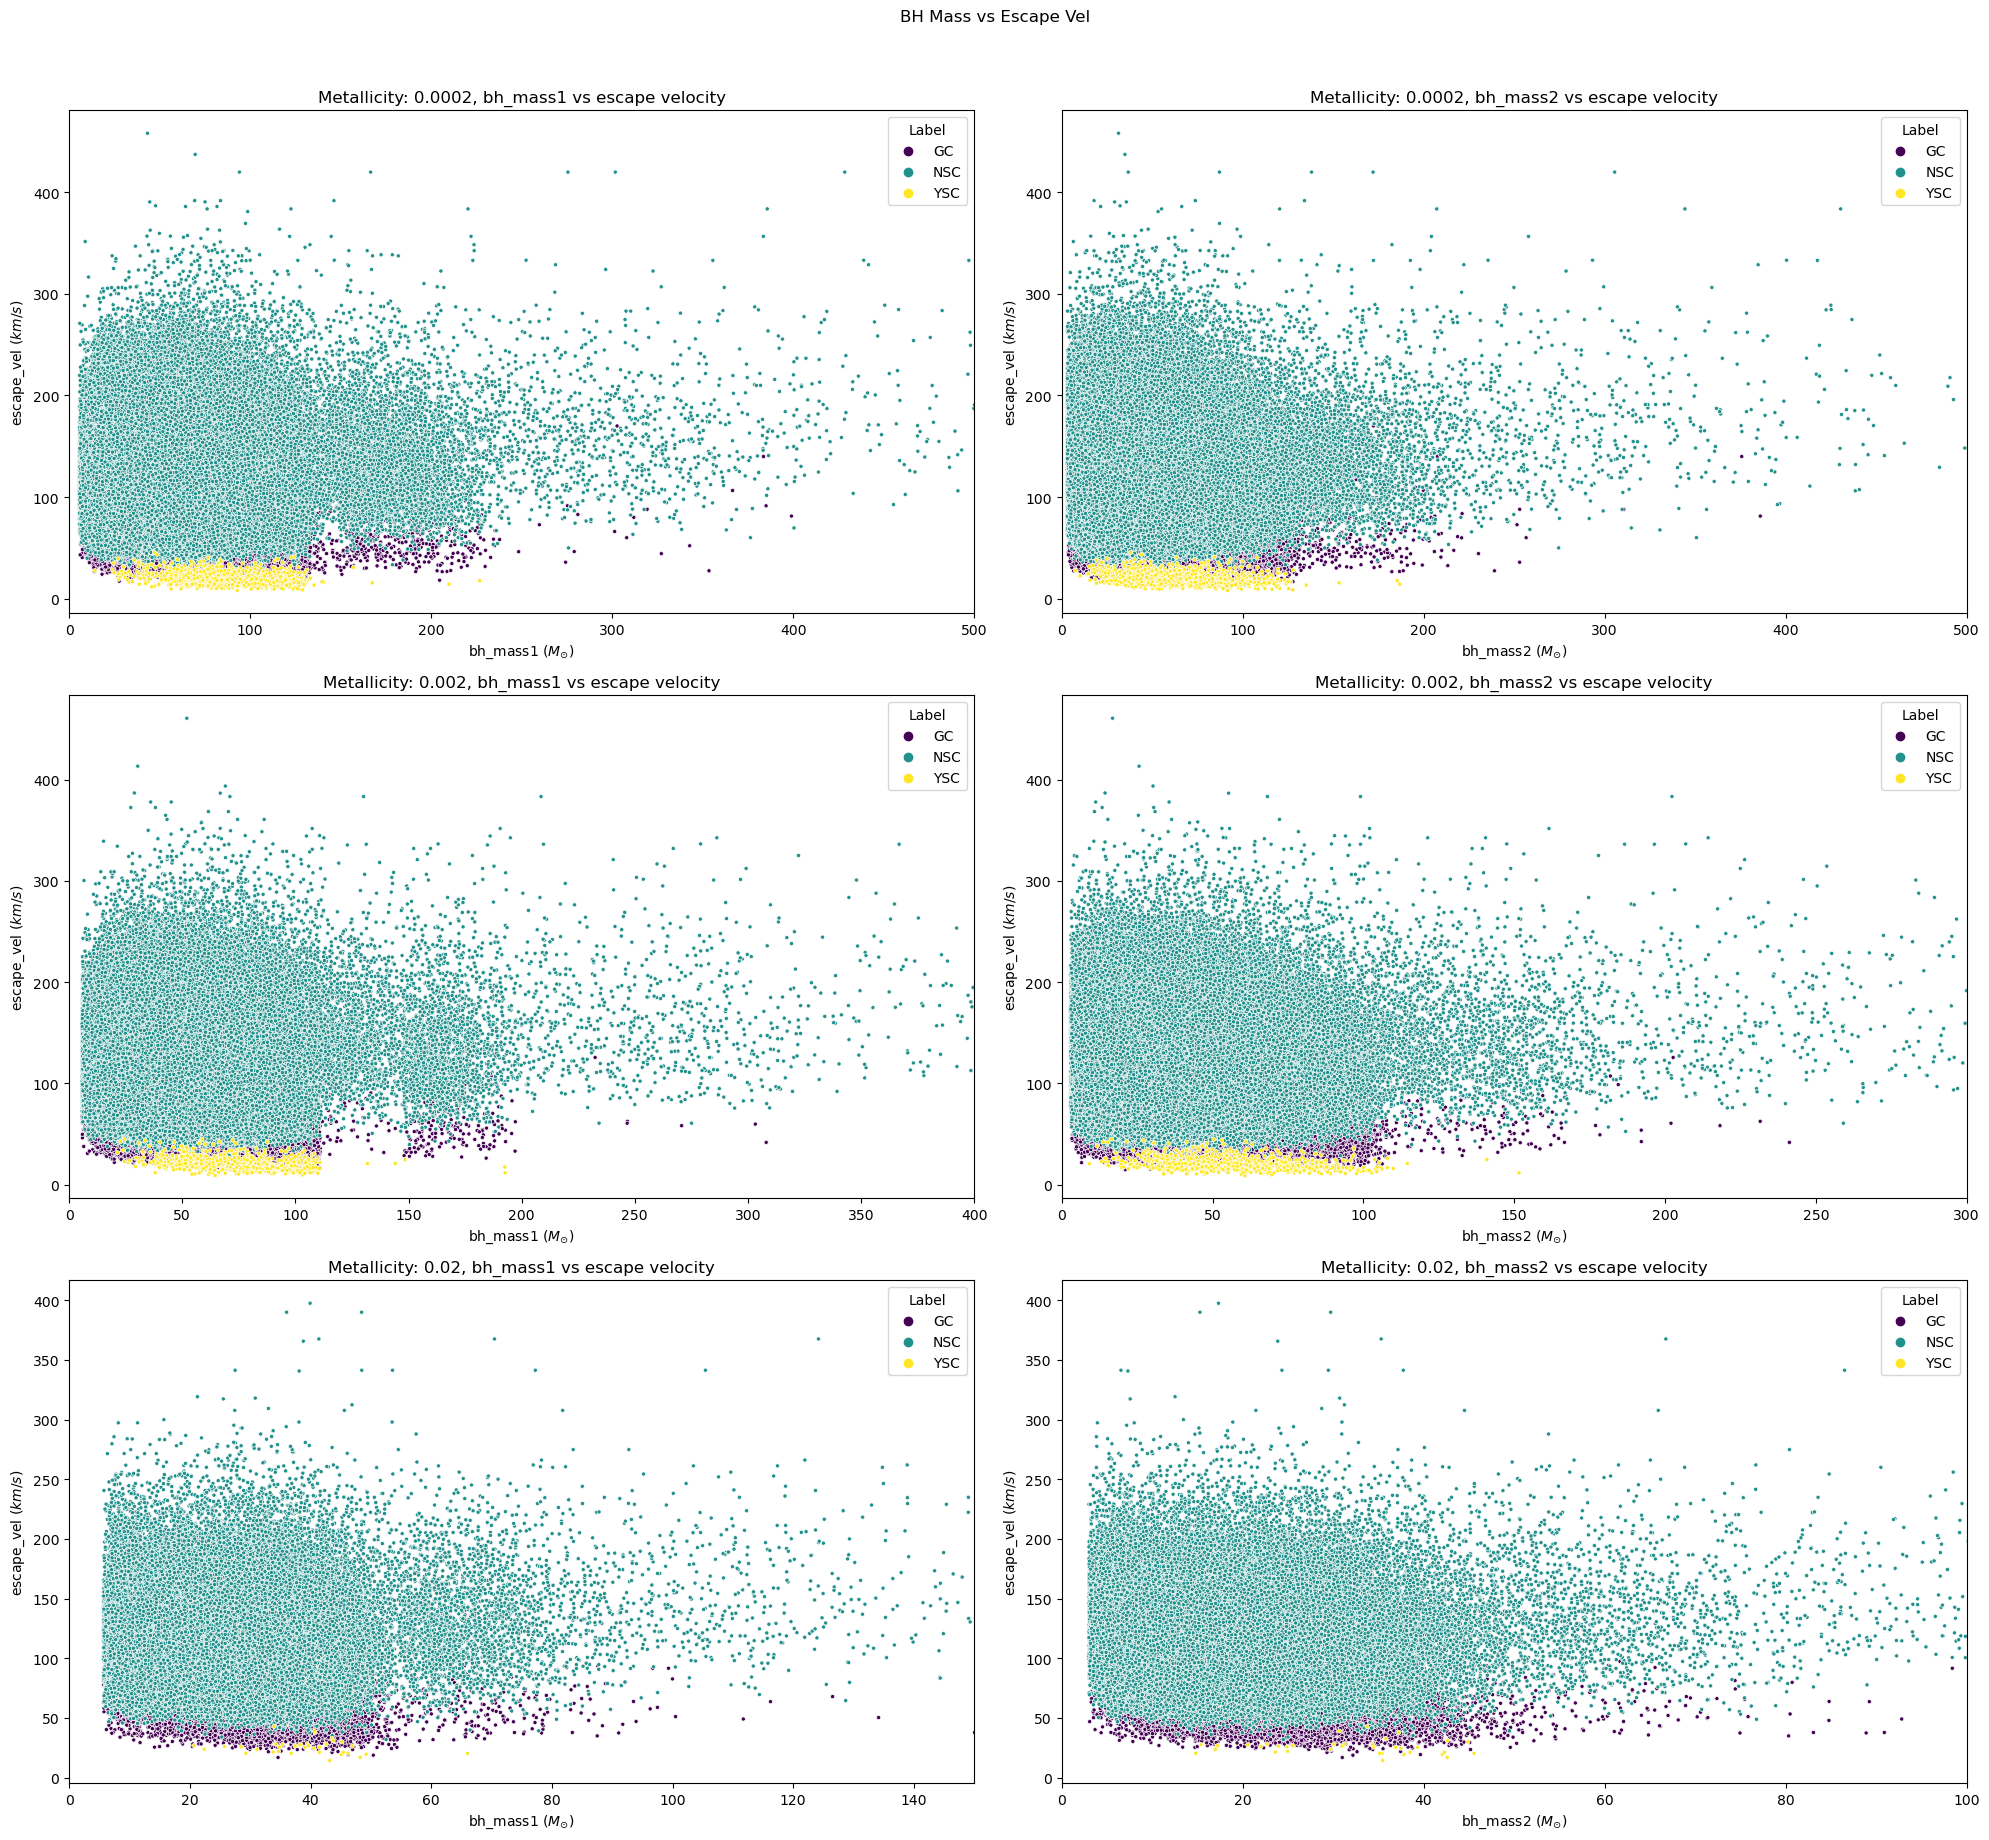

In [69]:
# Define custom label mapping
label_mapping = {0: 'GC', 1: 'NSC', 2: 'YSC'}

# Convert selected_metallicities to float
selected_metallicities = [float(x) for x in ['0.0002', '0.002', '0.02']]

# Create a separate subplot for each metallicity
fig, axs = plt.subplots(len(selected_metallicities), 2, figsize=(20, 6 * len(selected_metallicities)))

# Choose a color map
color_map = 'viridis' 

for i, met in enumerate(selected_metallicities):
    # Filter df for the current metallicity
    df_met = df.filter(df['met'] == met)

    # Plot the primary bh masses vs escape velocity
    sns.scatterplot(data=df_met.to_pandas(), x='bh_mass1', y='escape_vel', hue='label', marker='.', palette=color_map, ax=axs[i, 0])
    axs[i, 0].set_title(f'Metallicity: {met}, bh_mass1 vs escape velocity')
    axs[i, 0].set_xlabel(r'bh_mass1 ($M_{\odot}$)')
    axs[i, 0].set_ylabel(r'escape_vel ($km/s$)')
    axs[0, 0].set_xlim(0, 500) 
    axs[0,1].set_xlim(0, 500)
    axs[1, 0].set_xlim(0, 400)
    axs[1, 1].set_xlim(0, 300)
    axs[2, 0].set_xlim(0, 150)
    axs[2, 1].set_xlim(0, 100)
    

    # Plot the secondary bh masses vs escape velocity
    sns.scatterplot(data=df_met.to_pandas(), x='bh_mass2', y='escape_vel', hue='label', marker='.', palette=color_map, ax=axs[i, 1])
    axs[i, 1].set_title(f'Metallicity: {met}, bh_mass2 vs escape velocity')
    
    # Add a custom legend
    handles, labels = axs[i, 0].get_legend_handles_labels()
    axs[i, 0].legend(handles, [label_mapping[label] for label in sorted(df_met['label'].unique())], title='Label')
    axs[i, 1].legend(handles, [label_mapping[label] for label in sorted(df_met['label'].unique())], title='Label')
    axs[i, 1].set_xlabel(r'bh_mass2 ($M_{\odot}$)')
    axs[i, 1].set_ylabel(r'escape_vel ($km/s$)')
    #Add title
    fig.suptitle('BH Mass vs Escape Vel', y=1.02)

plt.tight_layout()
plt.show()

We show the distribution of the masses of the primary and secondary BHs with respect to the metallicity, one of the parameters designed as relevant in the previous analysis.

A similar behaviour is experienced for the three different metallicities. The higher escape velocities associated to NSCs (in the range $100 \, \text{km/s} \lesssim \texttt{escape\_vel} \lesssim 400 \, \text{km/s}$) relate to higher BH masses (up to $500 \, M_\odot$). 

YSCs and GCs share lower velocities ($ < 100 \, \text{km/s}$). Regarding the masses, the range change with the metallicity: higher metallicities are associated with lower masses. In general for these two clusters, the masses are of the order of $100 \, M_\odot$.

### Mass of the BH remnant VS Metallicity

In the following plot, we can see which range of BH remnant masses is reached according to the metallicity and the cluster. NSCs show the higher masses to be concentrated at lower metallicities. YSCs have a similar trend for all metallicities, maintaing the values of the masses of the order of $10^2 M_\odot$. For GCs, the systems are almost equally distributed, reachign masses on average in the range of $200 \,  M_\odot \lesssim \texttt{remnant\_mass} \lesssim 600 \, M_\odot$.

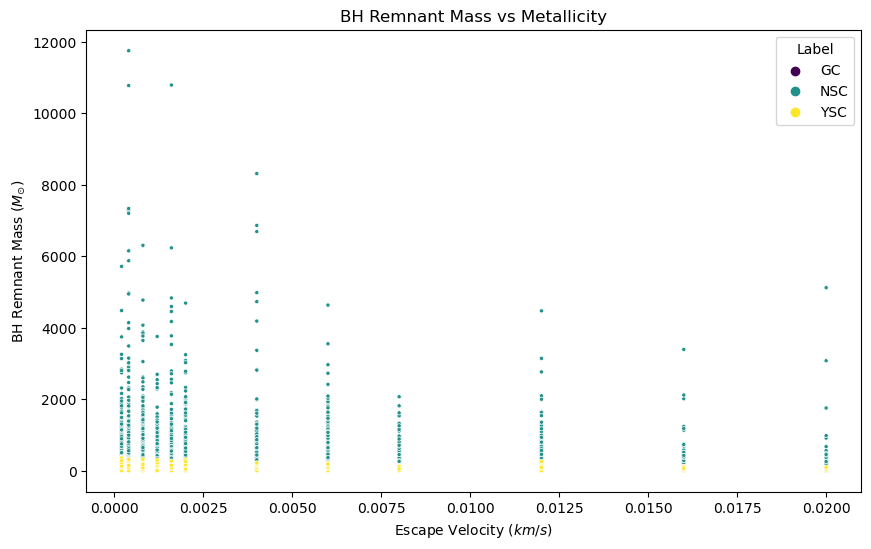

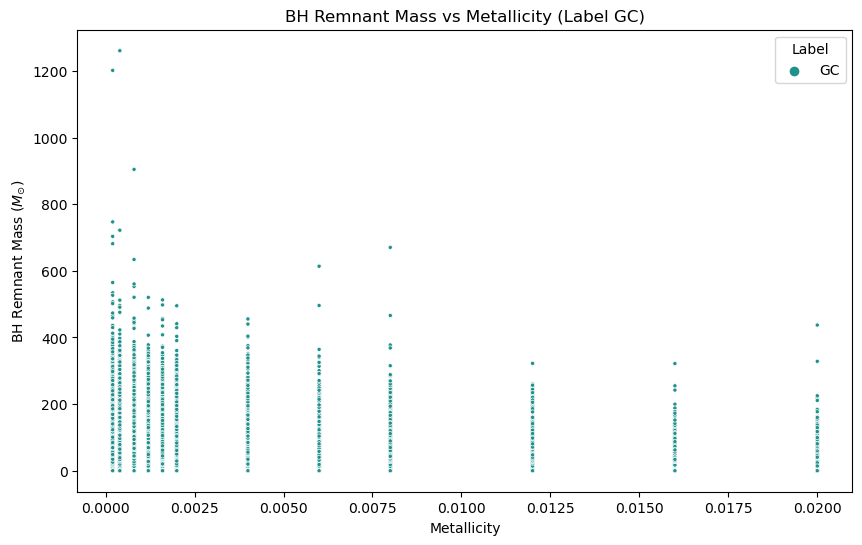

In [23]:
# Define custom label mapping
label_mapping = {0: 'GC', 1: 'NSC', 2: 'YSC'}

# Scatterplot with a different color palette
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(data=df.to_pandas(), x='met', y='remnant_mass', hue='label', marker='.', palette='viridis', zorder=-100)

# Create a custom legend
legend = plt.legend(title="Label")
for i, label in enumerate(sorted(df['label'].unique())):
    legend.get_texts()[i].set_text(label_mapping[label])

# Set plot title and labels
plt.title('BH Remnant Mass vs Metallicity')
plt.xlabel(r'Metallicity')
plt.ylabel(r'BH Remnant Mass ($M_{\odot}$)')

plt.show()

# Create a separate scatter plot for label 0
plt.figure(figsize=(10, 6))
# Filter the DataFrame for label == 0
df_label_0 = df.filter(df['label'] == 0)
sns.scatterplot(data=df_label_0.to_pandas(), x='met', y='remnant_mass', hue='label', marker='.', palette='viridis', zorder=-100)

# Create a custom legend
legend = plt.legend(title="Label")
for i, label in enumerate(sorted(df_label_0['label'].unique())):
    legend.get_texts()[i].set_text(label_mapping[label])

# Set plot title and labels for the separate plot
plt.title('BH Remnant Mass vs Metallicity (Label GC)')
plt.xlabel(r'Metallicity')
plt.ylabel(r'BH Remnant Mass ($M_{\odot}$)')

plt.show()

## BH Remnant Mass VS Escape Velocity

In the following plots, we show the distribution of the BH remanant mass with respect to the escape velocity, distinguishing between the three hosting bodies.

NSCs confirm to have the higher escape velocities, producing the heaviest remnants (up to $4000 \, M_\odot$.) YSCs concentrate at low escape velocities ($< 100 \, km/s$) and reaching masses $< 500 \, M_\odot$. A similar behaviour can be found for the GCs: these systems have low escape velocities of the order of $10^2 \, km/s$, with the BH remnants reaching at most $\approx 10^3 M_\odot$.

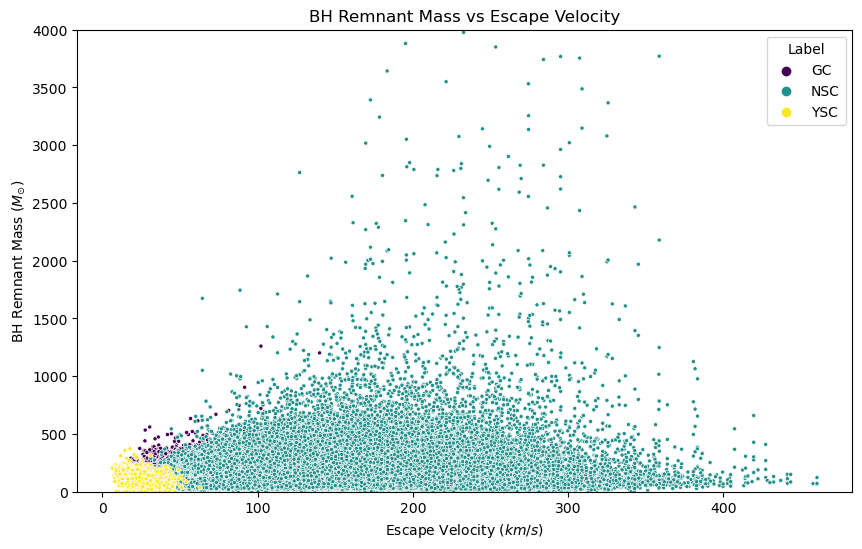

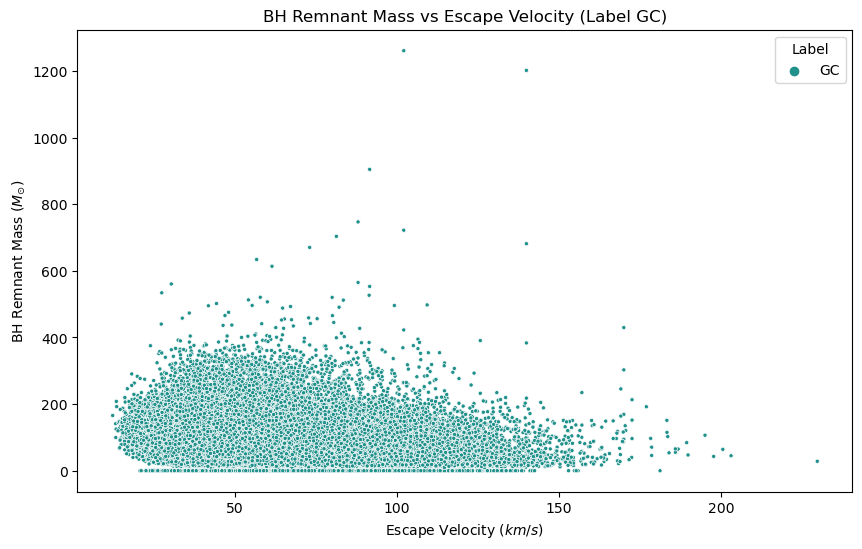

In [26]:
# Define custom label mapping
label_mapping = {0: 'GC', 1: 'NSC', 2: 'YSC'}

# Scatterplot with a different color palette
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(data=df.to_pandas(), x='escape_vel', y='remnant_mass', hue='label', marker='.', palette='viridis', zorder=-100)

# Create a custom legend
legend = plt.legend(title="Label")
for i, label in enumerate(sorted(df['label'].unique())):
    legend.get_texts()[i].set_text(label_mapping[label])

# Set plot title and labels
plt.title('BH Remnant Mass vs Escape Velocity')
plt.xlabel(r'Escape Velocity ($km/s$)')
plt.ylabel(r'BH Remnant Mass ($M_{\odot}$)')
plt.ylim(0, 4000)

plt.show()

# Create a separate scatter plot for label 0
plt.figure(figsize=(10, 6))
# Filter the DataFrame for label == 0
df_label_0 = df.filter(df['label'] == 0)
sns.scatterplot(data=df_label_0.to_pandas(), x='escape_vel', y='remnant_mass', hue='label', marker='.', palette='viridis', zorder=-100)

# Create a custom legend
legend = plt.legend(title="Label")
for i, label in enumerate(sorted(df_label_0['label'].unique())):
    legend.get_texts()[i].set_text(label_mapping[label])

# Set plot title and labels for the separate plot
plt.title('BH Remnant Mass vs Escape Velocity (Label GC)')
plt.xlabel(r'Escape Velocity ($km/s$)')
plt.ylabel(r'BH Remnant Mass ($M_{\odot}$)')

plt.show()

### Simple Random Forest

In [6]:
def simple_RF(X_train: npt.NDArray, y_train: npt.NDArray, X_test: npt.NDArray, random_state: int=42) -> Tuple[RandomForestClassifier, npt.NDArray]:
    
    """
    Function that takes in input the preprocessed data and returns a simple Random Forest model.

    :params X_train: training features
    :params y_train: training target
    :params X_test: testing features
    :params random_state: random state for reproducibility
    :return: a tuple with the model, the predictions target: model, y_pred
    
    """

    # Initialize the Random Forest Classifier
    RF = RandomForestClassifier(n_estimators=10, class_weight='balanced_subsample', criterion='entropy', random_state=random_state)

    # Fit the model to the training data
    RF.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = RF.predict(X_test)

    return RF, y_pred

def model_evaluation(model: RandomForestClassifier, X: npt.NDArray, y: npt.NDArray, X_train: npt.NDArray, y_train: npt.NDArray, X_test: npt.NDArray, y_test: npt.NDArray, y_pred: npt.NDArray) -> None:
    
    """
    Function that takes in input the model and the preprocessed data and returns the evaluation of the model: Training Score, Test Score, Confusion Matrix and Feature Importances.

    :params model: Random Forest model
    :params X: features
    :params y: target
    :params X_train: training features
    :params y_train: training target
    :params X_test: testing features
    :params y_test: testing target
    :params y_pred: model predictions
    :return: None 
    """

    #std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

    # Get feature importances
    importances = model.feature_importances_

    # Convert the importances into one-dimensional 1darray with corresponding df column names as axis labels
    f_importances = pd.Series(importances, X.columns)

    # Sort the array in descending order of the importances
    f_importances.sort_values(ascending=False, inplace=True)

    print("Training Score:", model.score(X_train, y_train))
    print("Test score (Accuracy):    ", model.score(X_test, y_test))
    print()

    # Plot the confusion matrix
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap=plt.cm.Greys, normalize='true', text_kw={'fontsize': 11})
    plt.title('Confusion Matrix')
    plt.show()

    # Make the bar Plot from f_importances 
    f_importances.plot(x='Features', y='Importance', kind='bar', figsize=(12, 4), rot=45, fontsize=11)#, yerr=std)

### Grid Search CV

In [ ]:
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 300, 500, 800],
    'max_depth': [5, 15, 25, 50],
    'min_samples_split': [5, 10, 15, 20, 30, 40 , 50, 60, 70, 80]
}

def gridsearch_RF(param_grid: dict, cv: int, X_train: npt.NDArray, y_train: npt.NDArray, X_test: npt.NDArray, n_jobs: int, random_state: int=42, verbose: int=2) -> Tuple[RandomForestClassifier, npt.NDArray, dict]:
    
    """
    Function that takes in input the parameter grid and the preprocessed data and returns the best model and the predictions.

    :params param_grid: parameter grid for the Grid Search
    :params cv: cross-validation folds
    :params X_train: training features
    :params y_train: training target
    :params X_test: testing features
    :params random_state: random state for reproducibility
    :params verbose: verbosity level
    :params n_jobs: number of jobs to run in parallel
    :return: a tuple with the best model and the predictions: model, y_pred
    
    """

    RF = RandomForestClassifier(criterion='entropy', class_weight='balanced_subsample', random_state=random_state)

    # Initialize the grid search model
    grid_search = GridSearchCV(estimator=RF, param_grid=param_grid, cv=cv, verbose=verbose, n_jobs=n_jobs, return_train_score=True)

    # Fit the grid search to the data
    grid_search.fit(X_train, y_train)

    # Get the best parameters
    best_params = grid_search.best_params_
    best_index = grid_search.best_index_

    print('Best parameters:', best_params)
    print('ID of the best combination:', best_index)

    # Fit the model with the best parameters
    RF_best = RandomForestClassifier(**best_params)
    RF_best.fit(X_train, y_train)

    # Predict on the test set
    y_pred = RF_best.predict(X_test)

    return RF_best, y_pred, grid_search

label
1    7460
0    7460
2    7460
Name: count, dtype: int64

Label count: label
0    1683
1    1676
2    1641
Name: count, dtype: int64
Training Score: 0.99525
Test score (Accuracy):     0.923



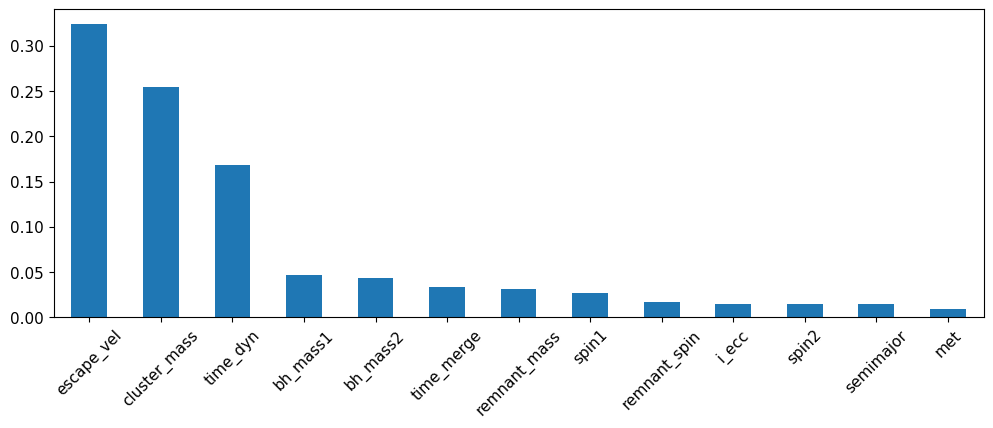

In [19]:
df_1 = df.filter(pl.col('label')==0)
X, y, X_train, y_train, X_test, y_test = data_preprocessing(df, n_sample=5000, label='label', test_size=0.2)


RF, y_pred = simple_RF(X_train, y_train, X_test)

model_evaluation(RF, X, y, X_train, y_train, X_test, y_test, y_pred)

In [ ]:
%%time
X, y, X_train, y_train, X_test, y_test = data_preprocessing(df, n_samples=10000, label='label', random_state=42, test_size=0.2)


RF_best, y_pred, grid_search = gridsearch_RF(param_grid=param_grid, cv=3, X_train=X_train, y_train=y_train, X_test=X_test, n_jobs=25)

model_evaluation(RF_best, X, y, X_train, y_train, X_test, y_test, y_pred)

In [ ]:
def model_scores(grid_search: dict, best_index: int) -> None:

    """
    Function that takes in input the grid search results and the best index and returns the mean test scores plot.

    :params grid_search: grid search results
    :params best_index: best index
    :return: None
    """
    # Get mean test scores
    mean_test_scores = grid_search.cv_results_['mean_test_score']
    mean_train_scores = grid_search.cv_results_['mean_train_score']

    # Plot mean test scores
    plt.figure(figsize=(10, 6))

    plt.plot(range(1, len(mean_test_scores)+1), mean_test_scores, label='Mean Test Score', color='blue')
    plt.plot(range(1, len(mean_train_scores)+1), mean_train_scores, label='Mean Train Score', color='orange')
    plt.xlabel('Index of hyperparameter combination')
    plt.vlines(x=best_index, ymin=0, ymax=1.2, color='green', label='Best combination')
    plt.ylabel('Mean Score')
    plt.legend(loc='best')
    plt.ylim(0.5, 1.1)
    plt.show()

In [ ]:
model_scores(grid_search, best_index=55)

In [ ]:
import shap

# Create object that can calculate shap values
explainer = shap.TreeExplainer(rf)

# Calculate Shap values
shap_values = explainer.shap_values(X_train[:150].values)

In [ ]:
fig = plt.figure()

ax0 = fig.add_subplot(211)
ax0.set_title('Non-evolved - 0')
shap.summary_plot(np.abs(shap_values[0]), X_test[:150], plot_type='violin', show=False)
ax0.set_xlabel('SHAP values (impact on output model)', fontsize=11)



ax1 = fig.add_subplot(212)
ax1.set_title('Evolved - 1')
shap.summary_plot(np.abs(shap_values[1]), X_test[:150], plot_type='violin', show=False)
ax1.set_xlabel('SHAP values (impact on output model)', fontsize=11)


# ax2 = fig.add_subplot(313)
# plt.title('Class 0 - CE')
# shap.summary_plot(shap_values[0], X_test[:150], plot_type='violin', show=False)
# plt.xlabel('SHAP values (impact on output model)', fontsize=11)

plt.subplots_adjust(hspace = 50)
plt.gcf().set_size_inches(7,10)
plt.tight_layout()
plt.show()

In [ ]:
import shap
shap_values = shap.TreeExplainer(rf).shap_values(X_test[:150])
shap.summary_plot(shap_values, X_test[:150])